<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Acc_Class_Cat_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version History

- Dec 1 - Created.
- Dec 2
    - Added folder concat
    - Added model checkpoint saving
    - Added raw train tester
    - Tested on augmented data

## Config

In [13]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy"

aug = True

if aug:
    train_set_folders = ["ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy" 
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [6]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Base Arch

In [10]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 5, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

    

## Data Gen

Array shape is (27, 1, 13, 431)
13


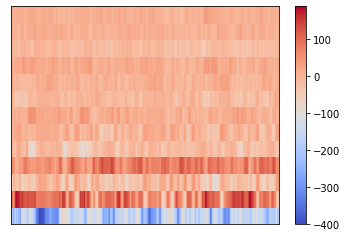

In [14]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

## Train Func

In [ ]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda().transpose(1,2)
            # print(input_array.shape)
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_rnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, "_checkpoint_subdir")
        full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
        try:
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        except FileNotFoundError:
            os.makedirs(full_checkpoint_path)
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

In [15]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            #input_array = imgs.float()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, "_checkpoint_subdir")
        full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
        try:
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        except FileNotFoundError:
            os.makedirs(full_checkpoint_path)
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### Exp 1: Base

Using CUDA
Epoch:  0 Train Accuracy:  0.40272456364410386 Val Accuracy:  0.6111111111111112 Progress:   3.33  % Time Elapsed:  264.76 s 
Epoch 0 Finished.  Time per Epoch:  264.76 s 
Epoch:  1 Train Accuracy:  0.5210727969348659 Val Accuracy:  0.42592592592592593 Progress:   6.67  % Time Elapsed:  286.29 s 
Epoch 1 Finished.  Time per Epoch:  143.14 s 
Epoch:  2 Train Accuracy:  0.5793954874414644 Val Accuracy:  0.42592592592592593 Progress:  10.00  % Time Elapsed:  307.66 s 
Epoch 2 Finished.  Time per Epoch:  102.55 s 
Epoch:  3 Train Accuracy:  0.6083439761600681 Val Accuracy:  0.5 Progress:  13.33  % Time Elapsed:  328.98 s 
Epoch 3 Finished.  Time per Epoch:  82.24 s 
Epoch:  4 Train Accuracy:  0.6398467432950191 Val Accuracy:  0.4444444444444444 Progress:  16.67  % Time Elapsed:  350.29 s 
Epoch 4 Finished.  Time per Epoch:  70.06 s 
Epoch:  5 Train Accuracy:  0.6577266922094508 Val Accuracy:  0.5 Progress:  20.00  % Time Elapsed:  371.45 s 
Epoch 5 Finished.  Time per Epoch:  61

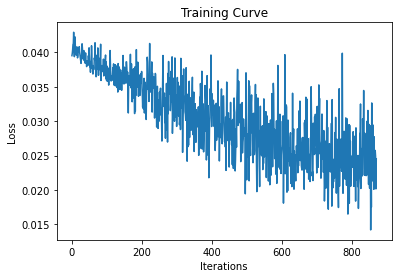

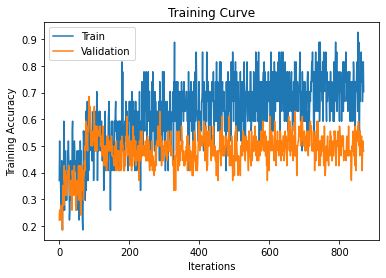

Epoch:  10 Train Accuracy:  0.7445721583652618 Val Accuracy:  0.5555555555555556 Progress:  36.67  % Time Elapsed:  478.12 s 
Epoch 10 Finished.  Time per Epoch:  43.47 s 
Epoch:  11 Train Accuracy:  0.7547892720306514 Val Accuracy:  0.5370370370370371 Progress:  40.00  % Time Elapsed:  499.62 s 
Epoch 11 Finished.  Time per Epoch:  41.63 s 
Epoch:  12 Train Accuracy:  0.7543635589612601 Val Accuracy:  0.4444444444444444 Progress:  43.33  % Time Elapsed:  520.84 s 
Epoch 12 Finished.  Time per Epoch:  40.06 s 
Epoch:  13 Train Accuracy:  0.7633035334184759 Val Accuracy:  0.5370370370370371 Progress:  46.67  % Time Elapsed:  542.02 s 
Epoch 13 Finished.  Time per Epoch:  38.72 s 
Epoch:  14 Train Accuracy:  0.7777777777777778 Val Accuracy:  0.5185185185185185 Progress:  50.00  % Time Elapsed:  563.17 s 
Epoch 14 Finished.  Time per Epoch:  37.54 s 
Epoch:  15 Train Accuracy:  0.789272030651341 Val Accuracy:  0.5185185185185185 Progress:  53.33  % Time Elapsed:  584.49 s 
Epoch 15 Finish

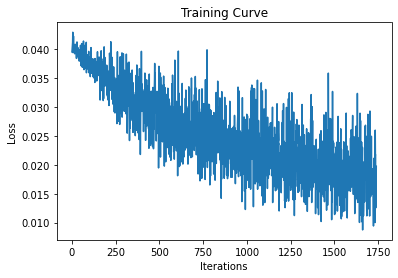

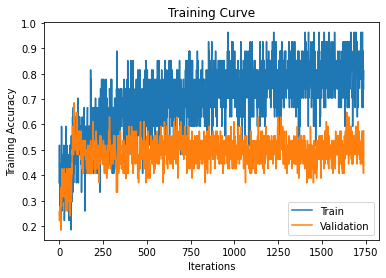

Epoch:  20 Train Accuracy:  0.8177948063005535 Val Accuracy:  0.5925925925925926 Progress:  70.00  % Time Elapsed:  691.15 s 
Epoch 20 Finished.  Time per Epoch:  32.91 s 
Epoch:  21 Train Accuracy:  0.8284376330353341 Val Accuracy:  0.5555555555555556 Progress:  73.33  % Time Elapsed:  712.47 s 
Epoch 21 Finished.  Time per Epoch:  32.39 s 
Epoch:  22 Train Accuracy:  0.8424861643252448 Val Accuracy:  0.5555555555555556 Progress:  76.67  % Time Elapsed:  734.32 s 
Epoch 22 Finished.  Time per Epoch:  31.93 s 
Epoch:  23 Train Accuracy:  0.8420604512558536 Val Accuracy:  0.46296296296296297 Progress:  80.00  % Time Elapsed:  755.63 s 
Epoch 23 Finished.  Time per Epoch:  31.48 s 
Epoch:  24 Train Accuracy:  0.8378033205619413 Val Accuracy:  0.5740740740740741 Progress:  83.33  % Time Elapsed:  776.97 s 
Epoch 24 Finished.  Time per Epoch:  31.08 s 
Epoch:  25 Train Accuracy:  0.8441890166028098 Val Accuracy:  0.5185185185185185 Progress:  86.67  % Time Elapsed:  798.45 s 
Epoch 25 Fini

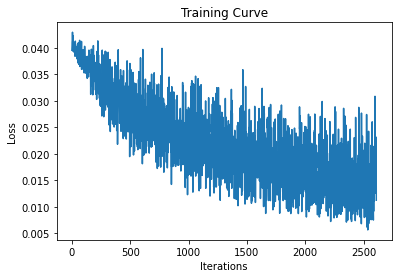

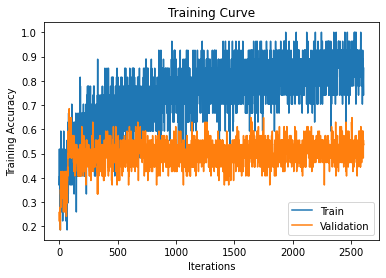

Finished Training
Total time:   881.85 s  Time per Epoch:  29.40 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "base_RNN_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes , batch_size, name)
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 2 - Changed nonlinearity to relu

Using CUDA
Epoch:  0 Train Accuracy:  0.39676458067262665 Val Accuracy:  0.42592592592592593 Progress:   3.33  % Time Elapsed:  22.04 s 
Epoch 0 Finished.  Time per Epoch:  22.04 s 
Epoch:  1 Train Accuracy:  0.5495955725840783 Val Accuracy:  0.5555555555555556 Progress:   6.67  % Time Elapsed:  44.06 s 
Epoch 1 Finished.  Time per Epoch:  22.03 s 
Epoch:  2 Train Accuracy:  0.6406981694338016 Val Accuracy:  0.5740740740740741 Progress:  10.00  % Time Elapsed:  65.73 s 
Epoch 2 Finished.  Time per Epoch:  21.91 s 
Epoch:  3 Train Accuracy:  0.7015751383567476 Val Accuracy:  0.5740740740740741 Progress:  13.33  % Time Elapsed:  87.10 s 
Epoch 3 Finished.  Time per Epoch:  21.78 s 
Epoch:  4 Train Accuracy:  0.7598978288633461 Val Accuracy:  0.48148148148148145 Progress:  16.67  % Time Elapsed:  108.27 s 
Epoch 4 Finished.  Time per Epoch:  21.65 s 
Epoch:  5 Train Accuracy:  0.8067262664963815 Val Accuracy:  0.5740740740740741 Progress:  20.00  % Time Elapsed:  129.21 s 
Epoch 5 Finishe

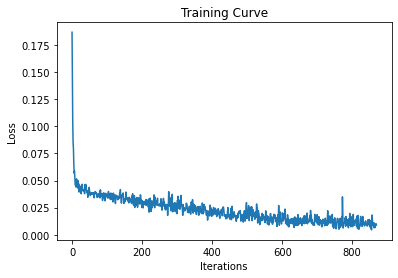

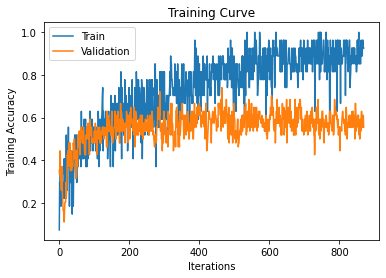

Epoch:  10 Train Accuracy:  0.9157088122605364 Val Accuracy:  0.5185185185185185 Progress:  36.67  % Time Elapsed:  233.33 s 
Epoch 10 Finished.  Time per Epoch:  21.21 s 
Epoch:  11 Train Accuracy:  0.924223073648361 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  254.25 s 
Epoch 11 Finished.  Time per Epoch:  21.19 s 
Epoch:  12 Train Accuracy:  0.9323116219667944 Val Accuracy:  0.5 Progress:  43.33  % Time Elapsed:  274.66 s 
Epoch 12 Finished.  Time per Epoch:  21.13 s 
Epoch:  13 Train Accuracy:  0.94465730097914 Val Accuracy:  0.5555555555555556 Progress:  46.67  % Time Elapsed:  295.09 s 
Epoch 13 Finished.  Time per Epoch:  21.08 s 
Epoch:  14 Train Accuracy:  0.955725840783312 Val Accuracy:  0.5555555555555556 Progress:  50.00  % Time Elapsed:  315.53 s 
Epoch 14 Finished.  Time per Epoch:  21.04 s 
Epoch:  15 Train Accuracy:  0.9527458492975734 Val Accuracy:  0.5185185185185185 Progress:  53.33  % Time Elapsed:  336.70 s 
Epoch 15 Finished.  Time per Epoc

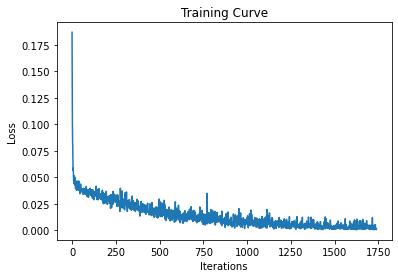

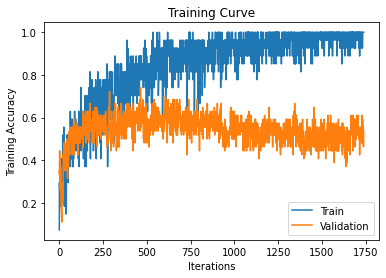

Epoch:  20 Train Accuracy:  0.9833971902937421 Val Accuracy:  0.5370370370370371 Progress:  70.00  % Time Elapsed:  439.48 s 
Epoch 20 Finished.  Time per Epoch:  20.93 s 
Epoch:  21 Train Accuracy:  0.9676458067262665 Val Accuracy:  0.5555555555555556 Progress:  73.33  % Time Elapsed:  460.03 s 
Epoch 21 Finished.  Time per Epoch:  20.91 s 
Epoch:  22 Train Accuracy:  0.9799914857386122 Val Accuracy:  0.5370370370370371 Progress:  76.67  % Time Elapsed:  480.60 s 
Epoch 22 Finished.  Time per Epoch:  20.90 s 
Epoch:  23 Train Accuracy:  0.9863771817794806 Val Accuracy:  0.5370370370370371 Progress:  80.00  % Time Elapsed:  501.22 s 
Epoch 23 Finished.  Time per Epoch:  20.88 s 
Epoch:  24 Train Accuracy:  0.9808429118773946 Val Accuracy:  0.5 Progress:  83.33  % Time Elapsed:  522.22 s 
Epoch 24 Finished.  Time per Epoch:  20.89 s 
Epoch:  25 Train Accuracy:  0.9893571732652192 Val Accuracy:  0.5555555555555556 Progress:  86.67  % Time Elapsed:  542.81 s 
Epoch 25 Finished.  Time per 

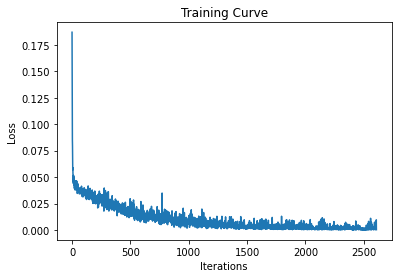

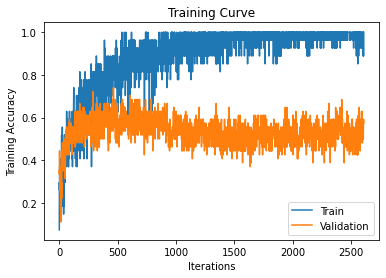

Finished Training
Total time:   625.35 s  Time per Epoch:  20.84 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "base_RNN_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp3 - Expanded fc classifier

In [ ]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name, nonlinearity='tanh', dropout=0):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    
    self.fc = nn.Sequential(nn.Linear(hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, num_classes),)
    self.batch_size = batch_size
    self.name = ("AccClassRNN_hiddensize%d_nonlinearity%s_dropout_%f"%(hidden_size, nonlinearity,dropout))
    self.name += name

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_classes, nonlinearity=nonlinearity, dropout=dropout)

  def forward(self, x):
    # Look up the embedding
    #print(x)
    #print(x.shape)
    #print(x.transpose(1,2).shape)
    #x = np.multiply(self.ident, x)
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

Using CUDA
Epoch:  0 Train Accuracy:  0.37718177948063003 Val Accuracy:  0.35185185185185186 Progress:   3.33  % Time Elapsed:  21.75 s 
Epoch 0 Finished.  Time per Epoch:  21.75 s 
Epoch:  1 Train Accuracy:  0.5053214133673903 Val Accuracy:  0.5370370370370371 Progress:   6.67  % Time Elapsed:  43.36 s 
Epoch 1 Finished.  Time per Epoch:  21.68 s 
Epoch:  2 Train Accuracy:  0.5930183056619838 Val Accuracy:  0.5925925925925926 Progress:  10.00  % Time Elapsed:  64.87 s 
Epoch 2 Finished.  Time per Epoch:  21.62 s 
Epoch:  3 Train Accuracy:  0.6836951894423159 Val Accuracy:  0.5555555555555556 Progress:  13.33  % Time Elapsed:  86.14 s 
Epoch 3 Finished.  Time per Epoch:  21.53 s 
Epoch:  4 Train Accuracy:  0.7254150702426565 Val Accuracy:  0.5740740740740741 Progress:  16.67  % Time Elapsed:  106.95 s 
Epoch 4 Finished.  Time per Epoch:  21.39 s 
Epoch:  5 Train Accuracy:  0.7650063856960408 Val Accuracy:  0.6666666666666666 Progress:  20.00  % Time Elapsed:  127.83 s 
Epoch 5 Finished

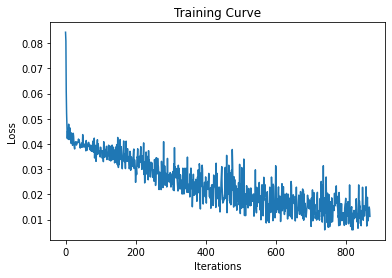

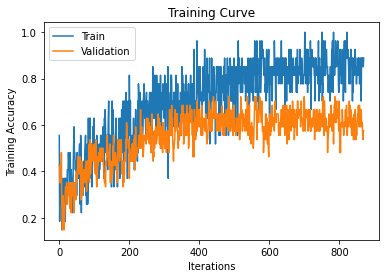

Epoch:  10 Train Accuracy:  0.8748403575989783 Val Accuracy:  0.6481481481481481 Progress:  36.67  % Time Elapsed:  232.24 s 
Epoch 10 Finished.  Time per Epoch:  21.11 s 
Epoch:  11 Train Accuracy:  0.8676032354193274 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  252.87 s 
Epoch 11 Finished.  Time per Epoch:  21.07 s 
Epoch:  12 Train Accuracy:  0.887186036611324 Val Accuracy:  0.5740740740740741 Progress:  43.33  % Time Elapsed:  273.49 s 
Epoch 12 Finished.  Time per Epoch:  21.04 s 
Epoch:  13 Train Accuracy:  0.9148573861217539 Val Accuracy:  0.6851851851851852 Progress:  46.67  % Time Elapsed:  294.11 s 
Epoch 13 Finished.  Time per Epoch:  21.01 s 
Epoch:  14 Train Accuracy:  0.9237973605789698 Val Accuracy:  0.6851851851851852 Progress:  50.00  % Time Elapsed:  314.72 s 
Epoch 14 Finished.  Time per Epoch:  20.98 s 
Epoch:  15 Train Accuracy:  0.9293316304810557 Val Accuracy:  0.5925925925925926 Progress:  53.33  % Time Elapsed:  335.34 s 
Epoch 15 Finish

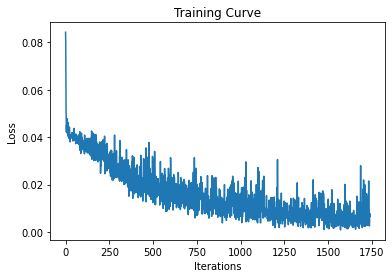

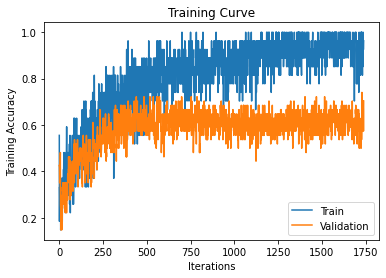

Epoch:  20 Train Accuracy:  0.9591315453384419 Val Accuracy:  0.6296296296296297 Progress:  70.00  % Time Elapsed:  438.50 s 
Epoch 20 Finished.  Time per Epoch:  20.88 s 
Epoch:  21 Train Accuracy:  0.9719029374201787 Val Accuracy:  0.6481481481481481 Progress:  73.33  % Time Elapsed:  459.59 s 
Epoch 21 Finished.  Time per Epoch:  20.89 s 
Epoch:  22 Train Accuracy:  0.9616858237547893 Val Accuracy:  0.6296296296296297 Progress:  76.67  % Time Elapsed:  484.17 s 
Epoch 22 Finished.  Time per Epoch:  21.05 s 
Epoch:  23 Train Accuracy:  0.9838229033631333 Val Accuracy:  0.5555555555555556 Progress:  80.00  % Time Elapsed:  508.66 s 
Epoch 23 Finished.  Time per Epoch:  21.19 s 
Epoch:  24 Train Accuracy:  0.9693486590038314 Val Accuracy:  0.5925925925925926 Progress:  83.33  % Time Elapsed:  532.79 s 
Epoch 24 Finished.  Time per Epoch:  21.31 s 
Epoch:  25 Train Accuracy:  0.9570029799914858 Val Accuracy:  0.6481481481481481 Progress:  86.67  % Time Elapsed:  557.57 s 
Epoch 25 Finis

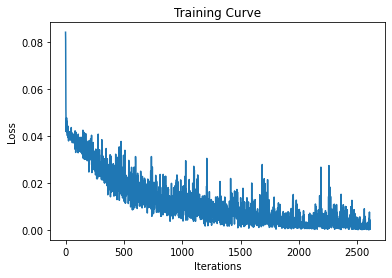

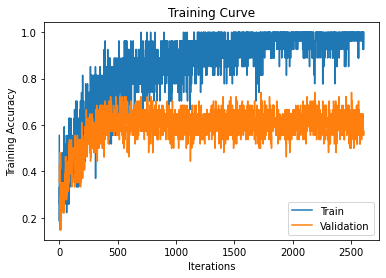

Finished Training
Total time:   656.70 s  Time per Epoch:  21.89 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "data_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 3 - Bigger fc layers

In [ ]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name, nonlinearity='tanh', dropout=0):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    
    self.fc = nn.Sequential(nn.Linear(hidden_size, 20),
                            nn.Linear(20, 10),
                            nn.Linear(10, num_classes),)
    self.batch_size = batch_size
    self.name = ("biggerfcl_AccClassRNN_hiddensize%d_nonlinearity%s_dropout_%f"%(hidden_size, nonlinearity,dropout))
    self.name += name

    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_classes, nonlinearity=nonlinearity, dropout=dropout)

  def forward(self, x):
    # Look up the embedding
    #print(x)
    #print(x.shape)
    #print(x.transpose(1,2).shape)
    #x = np.multiply(self.ident, x)
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

NameError: ignored

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 40
num_classes = 3
name = "data_ps1and2_gn0.05"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes, batch_size, name, nonlinearity="relu")
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Checking Model Performance on raw_10s

In [ ]:
test_net = AccClassRNN(mfcc_bands, hidden_size, num_classes , batch_size, name)
stupid_name = "AccClassRNN_" + name
if torch.cuda.is_available():
    test_net = test_net.cuda()
state = torch.load(os.path.join(model_checkpoints_abs_path, get_model_name(stupid_name, batch_size, learning_rate, "_checkpoint_subdir"), get_model_name(stupid_name, batch_size, learning_rate, 1)))
test_net.load_state_dict(state)

# make a raw train loader
data_transform = transforms.Compose([transforms.ToTensor()])
raw_train_data = torchvision.datasets.DatasetFolder(root=raw_dataset_path, loader=numpy_loader,extensions='.npy',transform=data_transform)
raw_train_loader = torch.utils.data.DataLoader(raw_train_data, batch_size=batch_size, num_workers=1, shuffle=True, drop_last=True)

get_accuracy_rnn(test_net, raw_train_loader)

0.7407407407407407

### Exp 4 - CRNNs (pogging out of our minds)

Using CUDA
Epoch:  0 Train Accuracy:  0.384418901660281 Val Accuracy:  0.3148148148148148 Progress:   3.33  % Time Elapsed:  395.80 s 
Epoch 0 Finished.  Time per Epoch:  395.81 s 
Epoch:  1 Train Accuracy:  0.513835674755215 Val Accuracy:  0.5555555555555556 Progress:   6.67  % Time Elapsed:  414.82 s 
Epoch 1 Finished.  Time per Epoch:  207.41 s 
Epoch:  2 Train Accuracy:  0.6147296722009365 Val Accuracy:  0.5 Progress:  10.00  % Time Elapsed:  433.69 s 
Epoch 2 Finished.  Time per Epoch:  144.56 s 
Epoch:  3 Train Accuracy:  0.6415495955725841 Val Accuracy:  0.6111111111111112 Progress:  13.33  % Time Elapsed:  452.58 s 
Epoch 3 Finished.  Time per Epoch:  113.14 s 
Epoch:  4 Train Accuracy:  0.709663686675181 Val Accuracy:  0.6111111111111112 Progress:  16.67  % Time Elapsed:  471.34 s 
Epoch 4 Finished.  Time per Epoch:  94.27 s 
Epoch:  5 Train Accuracy:  0.7590464027245637 Val Accuracy:  0.6481481481481481 Progress:  20.00  % Time Elapsed:  490.36 s 
Epoch 5 Finished.  Time per 

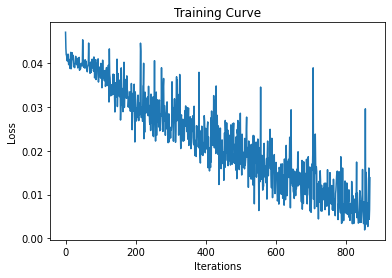

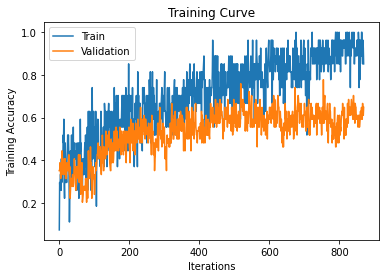

Epoch:  10 Train Accuracy:  0.9365687526607067 Val Accuracy:  0.5925925925925926 Progress:  36.67  % Time Elapsed:  586.03 s 
Epoch 10 Finished.  Time per Epoch:  53.28 s 
Epoch:  11 Train Accuracy:  0.9344401873137506 Val Accuracy:  0.5555555555555556 Progress:  40.00  % Time Elapsed:  604.88 s 
Epoch 11 Finished.  Time per Epoch:  50.41 s 
Epoch:  12 Train Accuracy:  0.9450830140485313 Val Accuracy:  0.6481481481481481 Progress:  43.33  % Time Elapsed:  623.81 s 
Epoch 12 Finished.  Time per Epoch:  47.99 s 
Epoch:  13 Train Accuracy:  0.9731800766283525 Val Accuracy:  0.5740740740740741 Progress:  46.67  % Time Elapsed:  642.81 s 
Epoch 13 Finished.  Time per Epoch:  45.92 s 
Epoch:  14 Train Accuracy:  0.9237973605789698 Val Accuracy:  0.5925925925925926 Progress:  50.00  % Time Elapsed:  661.95 s 
Epoch 14 Finished.  Time per Epoch:  44.13 s 
Epoch:  15 Train Accuracy:  0.9821200510855683 Val Accuracy:  0.5555555555555556 Progress:  53.33  % Time Elapsed:  680.95 s 
Epoch 15 Finis

KeyboardInterrupt: ignored

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
name = "data_ps1and2_gn0.05"

config = {
    "name": "CRNN_first_try",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 40,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

### Exp 5 - Beeg CRNN Raw 10s

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32,64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
name = "data_ps1and2_gn0.05"

config = {
    "name": "CRNN_Beeg_Raw_10s",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 40,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)

Using CUDA


RuntimeError: ignored

### Exp 1 (Cat)  - CRNN:

Dataset: raw_3classes_20bands_10s_npy_CRNN

Augmentation: "raw_3classes_20bands_10s_npy_CRNN_augmented_ps1",
                         "3classes_20bands_10s_npy_CRNN_augmented_gn0.07

Architecture: 1 conv layer (32 output, 3 kernel), 50 hidden units, 3 linear layers ( 25 -> 12, 12 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50 


In [15]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 25),
                                nn.Linear(25,12),
                            nn.Linear(12, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Epoch:  0 Train Accuracy:  0.4156378600823045 Val Accuracy:  0.3611111111111111 Progress:   1.00  % Time Elapsed:  17.72 s 
Epoch 0 Finished.  Time per Epoch:  17.72 s 
Epoch:  1 Train Accuracy:  0.39094650205761317 Val Accuracy:  0.37962962962962965 Progress:   2.00  % Time Elapsed:  35.39 s 
Epoch 1 Finished.  Time per Epoch:  17.70 s 
Epoch:  2 Train Accuracy:  0.38065843621399176 Val Accuracy:  0.32407407407407407 Progress:   3.00  % Time Elapsed:  52.96 s 
Epoch 2 Finished.  Time per Epoch:  17.66 s 
Epoch:  3 Train Accuracy:  0.4053497942386831 Val Accuracy:  0.3611111111111111 Progress:   4.00  % Time Elapsed:  70.75 s 
Epoch 3 Finished.  Time per Epoch:  17.69 s 
Epoch:  4 Train Accuracy:  0.4012345679012346 Val Accuracy:  0.35185185185185186 Progress:   5.00  % Time Elapsed:  88.60 s 
Epoch 4 Finished.  Time per Epoch:  17.72 s 


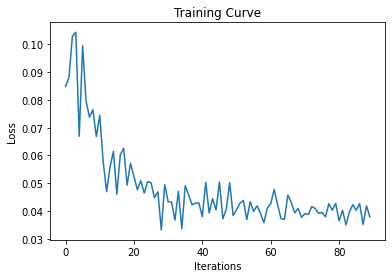

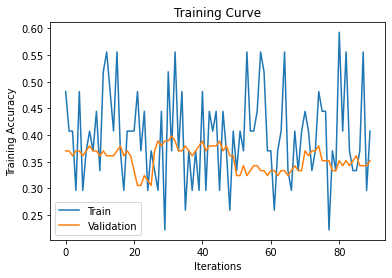

Epoch:  5 Train Accuracy:  0.4156378600823045 Val Accuracy:  0.35185185185185186 Progress:   6.00  % Time Elapsed:  107.00 s 
Epoch 5 Finished.  Time per Epoch:  17.83 s 
Epoch:  6 Train Accuracy:  0.4279835390946502 Val Accuracy:  0.3888888888888889 Progress:   7.00  % Time Elapsed:  125.43 s 
Epoch 6 Finished.  Time per Epoch:  17.92 s 
Epoch:  7 Train Accuracy:  0.4506172839506173 Val Accuracy:  0.37037037037037035 Progress:   8.00  % Time Elapsed:  143.33 s 
Epoch 7 Finished.  Time per Epoch:  17.92 s 
Epoch:  8 Train Accuracy:  0.4444444444444444 Val Accuracy:  0.37037037037037035 Progress:   9.00  % Time Elapsed:  161.14 s 
Epoch 8 Finished.  Time per Epoch:  17.90 s 
Epoch:  9 Train Accuracy:  0.4567901234567901 Val Accuracy:  0.37962962962962965 Progress:  10.00  % Time Elapsed:  178.78 s 
Epoch 9 Finished.  Time per Epoch:  17.88 s 


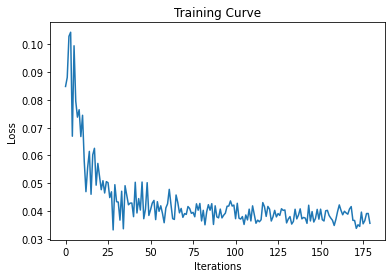

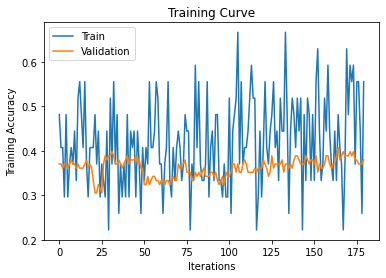

Epoch:  10 Train Accuracy:  0.4711934156378601 Val Accuracy:  0.3888888888888889 Progress:  11.00  % Time Elapsed:  199.47 s 
Epoch 10 Finished.  Time per Epoch:  18.13 s 
Epoch:  11 Train Accuracy:  0.46296296296296297 Val Accuracy:  0.3611111111111111 Progress:  12.00  % Time Elapsed:  220.23 s 
Epoch 11 Finished.  Time per Epoch:  18.35 s 
Epoch:  12 Train Accuracy:  0.4876543209876543 Val Accuracy:  0.3611111111111111 Progress:  13.00  % Time Elapsed:  240.95 s 
Epoch 12 Finished.  Time per Epoch:  18.53 s 
Epoch:  13 Train Accuracy:  0.5020576131687243 Val Accuracy:  0.37037037037037035 Progress:  14.00  % Time Elapsed:  261.90 s 
Epoch 13 Finished.  Time per Epoch:  18.71 s 
Epoch:  14 Train Accuracy:  0.4773662551440329 Val Accuracy:  0.37962962962962965 Progress:  15.00  % Time Elapsed:  282.25 s 
Epoch 14 Finished.  Time per Epoch:  18.82 s 


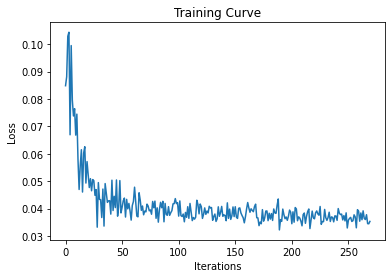

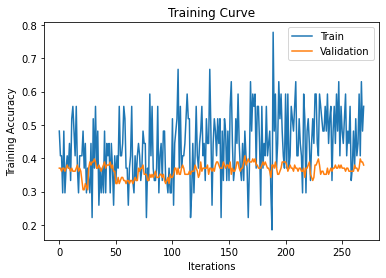

Epoch:  15 Train Accuracy:  0.5123456790123457 Val Accuracy:  0.35185185185185186 Progress:  16.00  % Time Elapsed:  300.58 s 
Epoch 15 Finished.  Time per Epoch:  18.79 s 
Epoch:  16 Train Accuracy:  0.5185185185185185 Val Accuracy:  0.37037037037037035 Progress:  17.00  % Time Elapsed:  318.23 s 
Epoch 16 Finished.  Time per Epoch:  18.72 s 
Epoch:  17 Train Accuracy:  0.5288065843621399 Val Accuracy:  0.3888888888888889 Progress:  18.00  % Time Elapsed:  335.98 s 
Epoch 17 Finished.  Time per Epoch:  18.67 s 
Epoch:  18 Train Accuracy:  0.5288065843621399 Val Accuracy:  0.4074074074074074 Progress:  19.00  % Time Elapsed:  353.66 s 
Epoch 18 Finished.  Time per Epoch:  18.61 s 
Epoch:  19 Train Accuracy:  0.551440329218107 Val Accuracy:  0.4537037037037037 Progress:  20.00  % Time Elapsed:  371.31 s 
Epoch 19 Finished.  Time per Epoch:  18.57 s 


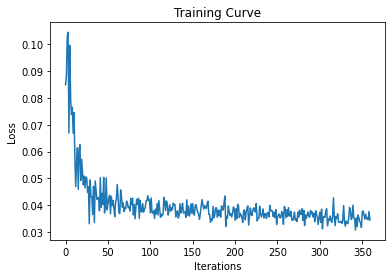

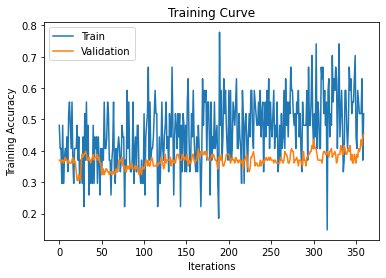

Epoch:  20 Train Accuracy:  0.5473251028806584 Val Accuracy:  0.42592592592592593 Progress:  21.00  % Time Elapsed:  389.31 s 
Epoch 20 Finished.  Time per Epoch:  18.54 s 
Epoch:  21 Train Accuracy:  0.5576131687242798 Val Accuracy:  0.42592592592592593 Progress:  22.00  % Time Elapsed:  407.14 s 
Epoch 21 Finished.  Time per Epoch:  18.51 s 
Epoch:  22 Train Accuracy:  0.6111111111111112 Val Accuracy:  0.4537037037037037 Progress:  23.00  % Time Elapsed:  425.10 s 
Epoch 22 Finished.  Time per Epoch:  18.48 s 
Epoch:  23 Train Accuracy:  0.5761316872427984 Val Accuracy:  0.48148148148148145 Progress:  24.00  % Time Elapsed:  443.57 s 
Epoch 23 Finished.  Time per Epoch:  18.48 s 
Epoch:  24 Train Accuracy:  0.6234567901234568 Val Accuracy:  0.5 Progress:  25.00  % Time Elapsed:  461.60 s 
Epoch 24 Finished.  Time per Epoch:  18.46 s 


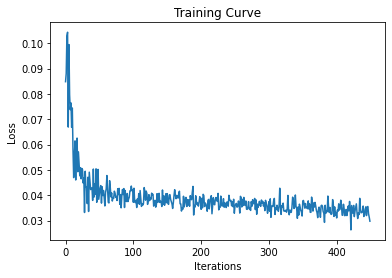

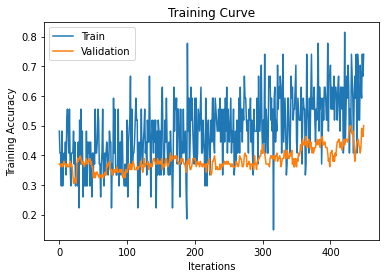

Epoch:  25 Train Accuracy:  0.5740740740740741 Val Accuracy:  0.5185185185185185 Progress:  26.00  % Time Elapsed:  479.56 s 
Epoch 25 Finished.  Time per Epoch:  18.44 s 
Epoch:  26 Train Accuracy:  0.6213991769547325 Val Accuracy:  0.5185185185185185 Progress:  27.00  % Time Elapsed:  497.17 s 
Epoch 26 Finished.  Time per Epoch:  18.41 s 
Epoch:  27 Train Accuracy:  0.6131687242798354 Val Accuracy:  0.5370370370370371 Progress:  28.00  % Time Elapsed:  514.97 s 
Epoch 27 Finished.  Time per Epoch:  18.39 s 
Epoch:  28 Train Accuracy:  0.6748971193415638 Val Accuracy:  0.5185185185185185 Progress:  29.00  % Time Elapsed:  532.62 s 
Epoch 28 Finished.  Time per Epoch:  18.37 s 
Epoch:  29 Train Accuracy:  0.6646090534979424 Val Accuracy:  0.5277777777777778 Progress:  30.00  % Time Elapsed:  550.32 s 
Epoch 29 Finished.  Time per Epoch:  18.34 s 


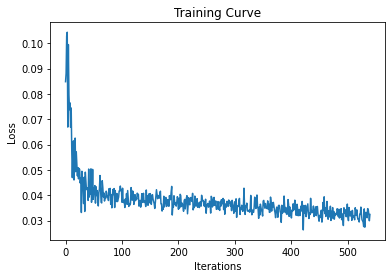

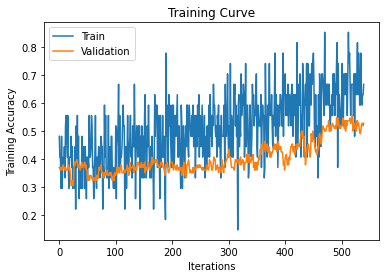

Epoch:  30 Train Accuracy:  0.6440329218106996 Val Accuracy:  0.5185185185185185 Progress:  31.00  % Time Elapsed:  568.35 s 
Epoch 30 Finished.  Time per Epoch:  18.33 s 
Epoch:  31 Train Accuracy:  0.676954732510288 Val Accuracy:  0.5462962962962963 Progress:  32.00  % Time Elapsed:  586.10 s 
Epoch 31 Finished.  Time per Epoch:  18.32 s 
Epoch:  32 Train Accuracy:  0.6584362139917695 Val Accuracy:  0.5740740740740741 Progress:  33.00  % Time Elapsed:  603.78 s 
Epoch 32 Finished.  Time per Epoch:  18.30 s 
Epoch:  33 Train Accuracy:  0.6872427983539094 Val Accuracy:  0.5925925925925926 Progress:  34.00  % Time Elapsed:  621.51 s 
Epoch 33 Finished.  Time per Epoch:  18.28 s 
Epoch:  34 Train Accuracy:  0.6522633744855967 Val Accuracy:  0.5370370370370371 Progress:  35.00  % Time Elapsed:  639.17 s 
Epoch 34 Finished.  Time per Epoch:  18.26 s 


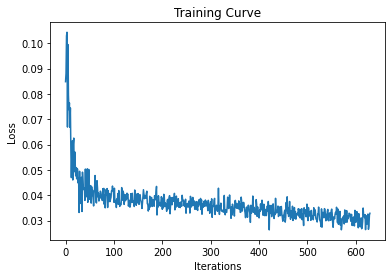

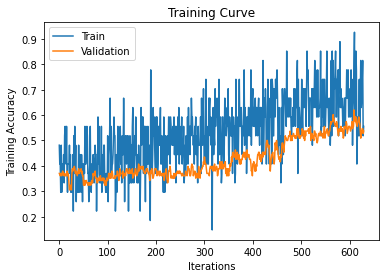

Epoch:  35 Train Accuracy:  0.7160493827160493 Val Accuracy:  0.5555555555555556 Progress:  36.00  % Time Elapsed:  657.11 s 
Epoch 35 Finished.  Time per Epoch:  18.25 s 
Epoch:  36 Train Accuracy:  0.7016460905349794 Val Accuracy:  0.5833333333333334 Progress:  37.00  % Time Elapsed:  674.64 s 
Epoch 36 Finished.  Time per Epoch:  18.23 s 
Epoch:  37 Train Accuracy:  0.7345679012345679 Val Accuracy:  0.6203703703703703 Progress:  38.00  % Time Elapsed:  692.27 s 
Epoch 37 Finished.  Time per Epoch:  18.22 s 
Epoch:  38 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5648148148148148 Progress:  39.00  % Time Elapsed:  709.87 s 
Epoch 38 Finished.  Time per Epoch:  18.20 s 
Epoch:  39 Train Accuracy:  0.7283950617283951 Val Accuracy:  0.6203703703703703 Progress:  40.00  % Time Elapsed:  727.38 s 
Epoch 39 Finished.  Time per Epoch:  18.18 s 


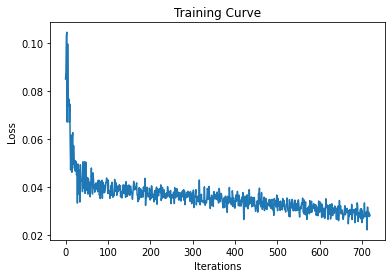

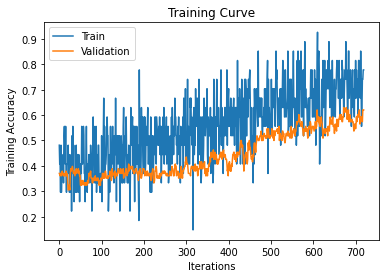

Epoch:  40 Train Accuracy:  0.7263374485596708 Val Accuracy:  0.6018518518518519 Progress:  41.00  % Time Elapsed:  745.35 s 
Epoch 40 Finished.  Time per Epoch:  18.18 s 
Epoch:  41 Train Accuracy:  0.7386831275720165 Val Accuracy:  0.5648148148148148 Progress:  42.00  % Time Elapsed:  766.11 s 
Epoch 41 Finished.  Time per Epoch:  18.24 s 
Epoch:  42 Train Accuracy:  0.7263374485596708 Val Accuracy:  0.6111111111111112 Progress:  43.00  % Time Elapsed:  784.07 s 
Epoch 42 Finished.  Time per Epoch:  18.23 s 
Epoch:  43 Train Accuracy:  0.7551440329218106 Val Accuracy:  0.6574074074074074 Progress:  44.00  % Time Elapsed:  801.77 s 
Epoch 43 Finished.  Time per Epoch:  18.22 s 
Epoch:  44 Train Accuracy:  0.7592592592592593 Val Accuracy:  0.6203703703703703 Progress:  45.00  % Time Elapsed:  819.43 s 
Epoch 44 Finished.  Time per Epoch:  18.21 s 


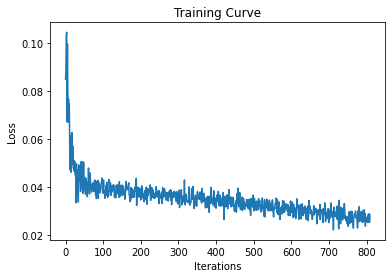

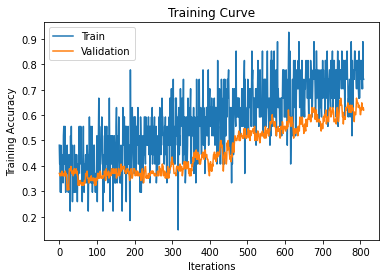

Epoch:  45 Train Accuracy:  0.7551440329218106 Val Accuracy:  0.6296296296296297 Progress:  46.00  % Time Elapsed:  837.59 s 
Epoch 45 Finished.  Time per Epoch:  18.21 s 
Epoch:  46 Train Accuracy:  0.7551440329218106 Val Accuracy:  0.6111111111111112 Progress:  47.00  % Time Elapsed:  855.39 s 
Epoch 46 Finished.  Time per Epoch:  18.20 s 
Epoch:  47 Train Accuracy:  0.7633744855967078 Val Accuracy:  0.6203703703703703 Progress:  48.00  % Time Elapsed:  873.15 s 
Epoch 47 Finished.  Time per Epoch:  18.19 s 
Epoch:  48 Train Accuracy:  0.7757201646090535 Val Accuracy:  0.6203703703703703 Progress:  49.00  % Time Elapsed:  891.03 s 
Epoch 48 Finished.  Time per Epoch:  18.18 s 
Epoch:  49 Train Accuracy:  0.7551440329218106 Val Accuracy:  0.6574074074074074 Progress:  50.00  % Time Elapsed:  908.90 s 
Epoch 49 Finished.  Time per Epoch:  18.18 s 


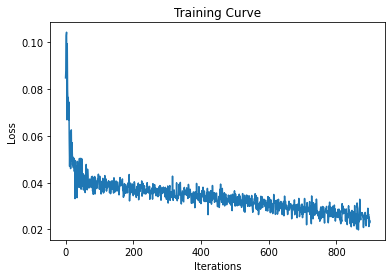

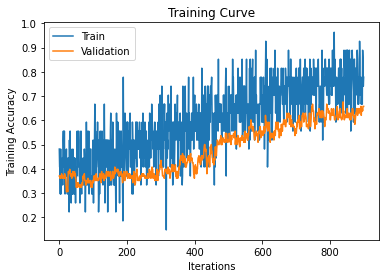

Epoch:  50 Train Accuracy:  0.779835390946502 Val Accuracy:  0.6296296296296297 Progress:  51.00  % Time Elapsed:  927.10 s 
Epoch 50 Finished.  Time per Epoch:  18.18 s 
Epoch:  51 Train Accuracy:  0.7901234567901234 Val Accuracy:  0.6481481481481481 Progress:  52.00  % Time Elapsed:  945.26 s 
Epoch 51 Finished.  Time per Epoch:  18.18 s 
Epoch:  52 Train Accuracy:  0.7839506172839507 Val Accuracy:  0.6203703703703703 Progress:  53.00  % Time Elapsed:  963.40 s 
Epoch 52 Finished.  Time per Epoch:  18.18 s 
Epoch:  53 Train Accuracy:  0.7839506172839507 Val Accuracy:  0.5740740740740741 Progress:  54.00  % Time Elapsed:  981.36 s 
Epoch 53 Finished.  Time per Epoch:  18.17 s 
Epoch:  54 Train Accuracy:  0.8065843621399177 Val Accuracy:  0.6111111111111112 Progress:  55.00  % Time Elapsed:  999.40 s 
Epoch 54 Finished.  Time per Epoch:  18.17 s 


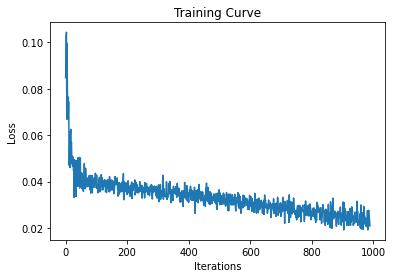

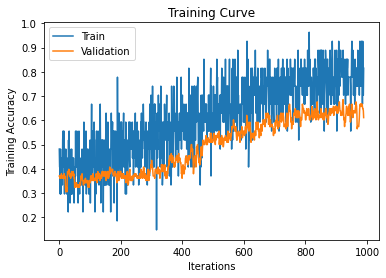

Epoch:  55 Train Accuracy:  0.7901234567901234 Val Accuracy:  0.6666666666666666 Progress:  56.00  % Time Elapsed:  1017.66 s 
Epoch 55 Finished.  Time per Epoch:  18.17 s 
Epoch:  56 Train Accuracy:  0.7942386831275721 Val Accuracy:  0.5925925925925926 Progress:  57.00  % Time Elapsed:  1035.41 s 
Epoch 56 Finished.  Time per Epoch:  18.17 s 
Epoch:  57 Train Accuracy:  0.7983539094650206 Val Accuracy:  0.6759259259259259 Progress:  58.00  % Time Elapsed:  1053.27 s 
Epoch 57 Finished.  Time per Epoch:  18.16 s 
Epoch:  58 Train Accuracy:  0.8024691358024691 Val Accuracy:  0.6759259259259259 Progress:  59.00  % Time Elapsed:  1071.85 s 
Epoch 58 Finished.  Time per Epoch:  18.17 s 
Epoch:  59 Train Accuracy:  0.8065843621399177 Val Accuracy:  0.6388888888888888 Progress:  60.00  % Time Elapsed:  1092.11 s 
Epoch 59 Finished.  Time per Epoch:  18.20 s 


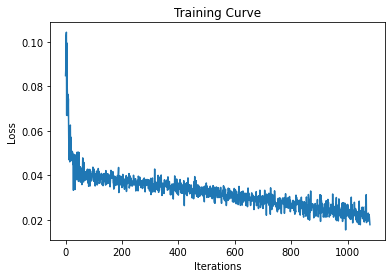

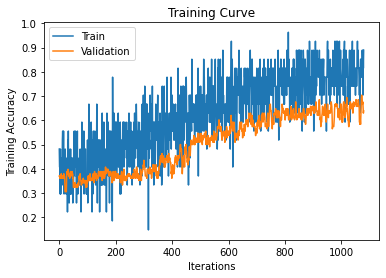

Epoch:  60 Train Accuracy:  0.7880658436213992 Val Accuracy:  0.6944444444444444 Progress:  61.00  % Time Elapsed:  1110.64 s 
Epoch 60 Finished.  Time per Epoch:  18.21 s 
Epoch:  61 Train Accuracy:  0.8333333333333334 Val Accuracy:  0.6759259259259259 Progress:  62.00  % Time Elapsed:  1128.50 s 
Epoch 61 Finished.  Time per Epoch:  18.20 s 
Epoch:  62 Train Accuracy:  0.823045267489712 Val Accuracy:  0.6759259259259259 Progress:  63.00  % Time Elapsed:  1146.28 s 
Epoch 62 Finished.  Time per Epoch:  18.19 s 
Epoch:  63 Train Accuracy:  0.8209876543209876 Val Accuracy:  0.6296296296296297 Progress:  64.00  % Time Elapsed:  1164.08 s 
Epoch 63 Finished.  Time per Epoch:  18.19 s 
Epoch:  64 Train Accuracy:  0.823045267489712 Val Accuracy:  0.6944444444444444 Progress:  65.00  % Time Elapsed:  1181.81 s 
Epoch 64 Finished.  Time per Epoch:  18.18 s 


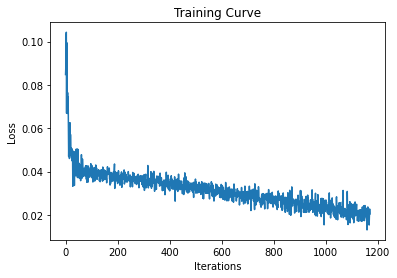

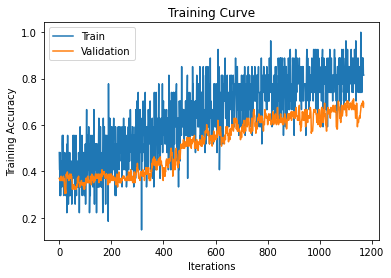

Epoch:  65 Train Accuracy:  0.8333333333333334 Val Accuracy:  0.6666666666666666 Progress:  66.00  % Time Elapsed:  1199.77 s 
Epoch 65 Finished.  Time per Epoch:  18.18 s 
Epoch:  66 Train Accuracy:  0.8374485596707819 Val Accuracy:  0.6944444444444444 Progress:  67.00  % Time Elapsed:  1217.83 s 
Epoch 66 Finished.  Time per Epoch:  18.18 s 
Epoch:  67 Train Accuracy:  0.8292181069958847 Val Accuracy:  0.6574074074074074 Progress:  68.00  % Time Elapsed:  1235.78 s 
Epoch 67 Finished.  Time per Epoch:  18.17 s 
Epoch:  68 Train Accuracy:  0.8395061728395061 Val Accuracy:  0.6759259259259259 Progress:  69.00  % Time Elapsed:  1253.92 s 
Epoch 68 Finished.  Time per Epoch:  18.17 s 
Epoch:  69 Train Accuracy:  0.8539094650205762 Val Accuracy:  0.6111111111111112 Progress:  70.00  % Time Elapsed:  1271.66 s 
Epoch 69 Finished.  Time per Epoch:  18.17 s 


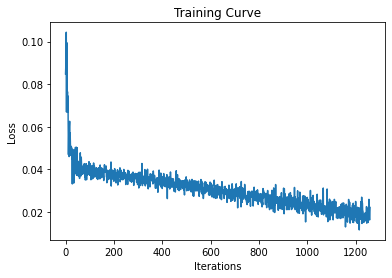

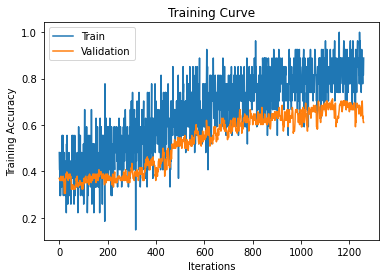

Epoch:  70 Train Accuracy:  0.8539094650205762 Val Accuracy:  0.6851851851851852 Progress:  71.00  % Time Elapsed:  1289.67 s 
Epoch 70 Finished.  Time per Epoch:  18.16 s 
Epoch:  71 Train Accuracy:  0.8559670781893004 Val Accuracy:  0.6759259259259259 Progress:  72.00  % Time Elapsed:  1307.45 s 
Epoch 71 Finished.  Time per Epoch:  18.16 s 
Epoch:  72 Train Accuracy:  0.8683127572016461 Val Accuracy:  0.6666666666666666 Progress:  73.00  % Time Elapsed:  1325.12 s 
Epoch 72 Finished.  Time per Epoch:  18.15 s 
Epoch:  73 Train Accuracy:  0.8600823045267489 Val Accuracy:  0.6574074074074074 Progress:  74.00  % Time Elapsed:  1343.06 s 
Epoch 73 Finished.  Time per Epoch:  18.15 s 
Epoch:  74 Train Accuracy:  0.8683127572016461 Val Accuracy:  0.6666666666666666 Progress:  75.00  % Time Elapsed:  1361.18 s 
Epoch 74 Finished.  Time per Epoch:  18.15 s 


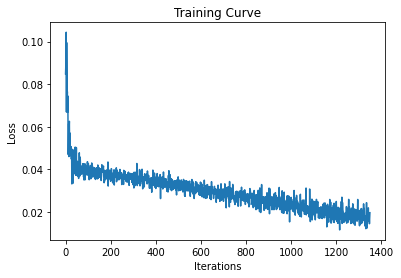

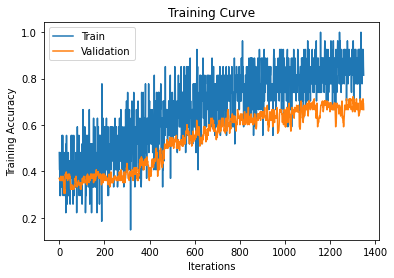

Epoch:  75 Train Accuracy:  0.8621399176954733 Val Accuracy:  0.6944444444444444 Progress:  76.00  % Time Elapsed:  1379.60 s 
Epoch 75 Finished.  Time per Epoch:  18.15 s 
Epoch:  76 Train Accuracy:  0.8621399176954733 Val Accuracy:  0.6666666666666666 Progress:  77.00  % Time Elapsed:  1397.65 s 
Epoch 76 Finished.  Time per Epoch:  18.15 s 
Epoch:  77 Train Accuracy:  0.8765432098765432 Val Accuracy:  0.6851851851851852 Progress:  78.00  % Time Elapsed:  1416.81 s 
Epoch 77 Finished.  Time per Epoch:  18.16 s 
Epoch:  78 Train Accuracy:  0.8786008230452675 Val Accuracy:  0.7222222222222222 Progress:  79.00  % Time Elapsed:  1434.58 s 
Epoch 78 Finished.  Time per Epoch:  18.16 s 
Epoch:  79 Train Accuracy:  0.8806584362139918 Val Accuracy:  0.6666666666666666 Progress:  80.00  % Time Elapsed:  1452.44 s 
Epoch 79 Finished.  Time per Epoch:  18.16 s 


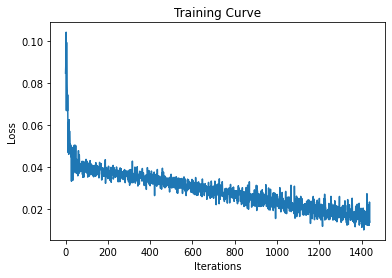

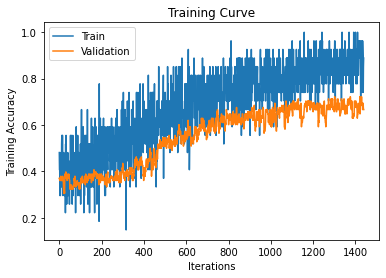

Epoch:  80 Train Accuracy:  0.8847736625514403 Val Accuracy:  0.7037037037037037 Progress:  81.00  % Time Elapsed:  1470.55 s 
Epoch 80 Finished.  Time per Epoch:  18.15 s 
Epoch:  81 Train Accuracy:  0.8744855967078189 Val Accuracy:  0.6481481481481481 Progress:  82.00  % Time Elapsed:  1488.41 s 
Epoch 81 Finished.  Time per Epoch:  18.15 s 
Epoch:  82 Train Accuracy:  0.8868312757201646 Val Accuracy:  0.6481481481481481 Progress:  83.00  % Time Elapsed:  1506.30 s 
Epoch 82 Finished.  Time per Epoch:  18.15 s 
Epoch:  83 Train Accuracy:  0.9032921810699589 Val Accuracy:  0.6666666666666666 Progress:  84.00  % Time Elapsed:  1524.06 s 
Epoch 83 Finished.  Time per Epoch:  18.14 s 
Epoch:  84 Train Accuracy:  0.8930041152263375 Val Accuracy:  0.6851851851851852 Progress:  85.00  % Time Elapsed:  1541.85 s 
Epoch 84 Finished.  Time per Epoch:  18.14 s 


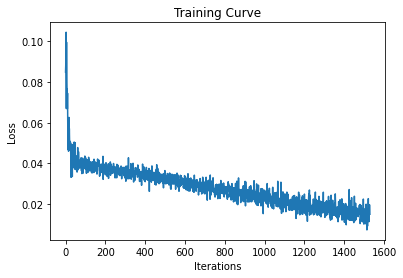

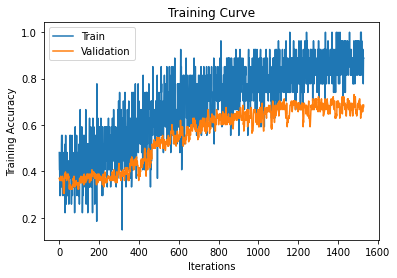

Epoch:  85 Train Accuracy:  0.8909465020576132 Val Accuracy:  0.6666666666666666 Progress:  86.00  % Time Elapsed:  1559.96 s 
Epoch 85 Finished.  Time per Epoch:  18.14 s 
Epoch:  86 Train Accuracy:  0.8909465020576132 Val Accuracy:  0.6851851851851852 Progress:  87.00  % Time Elapsed:  1577.85 s 
Epoch 86 Finished.  Time per Epoch:  18.14 s 
Epoch:  87 Train Accuracy:  0.897119341563786 Val Accuracy:  0.6666666666666666 Progress:  88.00  % Time Elapsed:  1595.82 s 
Epoch 87 Finished.  Time per Epoch:  18.13 s 
Epoch:  88 Train Accuracy:  0.9032921810699589 Val Accuracy:  0.7037037037037037 Progress:  89.00  % Time Elapsed:  1613.72 s 
Epoch 88 Finished.  Time per Epoch:  18.13 s 
Epoch:  89 Train Accuracy:  0.9135802469135802 Val Accuracy:  0.6851851851851852 Progress:  90.00  % Time Elapsed:  1631.60 s 
Epoch 89 Finished.  Time per Epoch:  18.13 s 


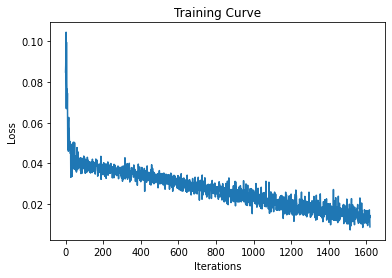

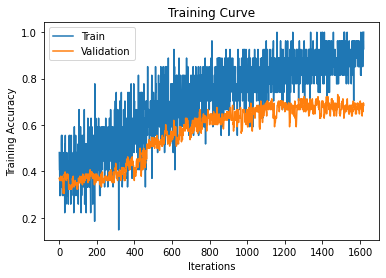

Epoch:  90 Train Accuracy:  0.897119341563786 Val Accuracy:  0.6851851851851852 Progress:  91.00  % Time Elapsed:  1649.74 s 
Epoch 90 Finished.  Time per Epoch:  18.13 s 
Epoch:  91 Train Accuracy:  0.9176954732510288 Val Accuracy:  0.6851851851851852 Progress:  92.00  % Time Elapsed:  1667.46 s 
Epoch 91 Finished.  Time per Epoch:  18.12 s 
Epoch:  92 Train Accuracy:  0.9176954732510288 Val Accuracy:  0.6666666666666666 Progress:  93.00  % Time Elapsed:  1685.39 s 
Epoch 92 Finished.  Time per Epoch:  18.12 s 
Epoch:  93 Train Accuracy:  0.9238683127572016 Val Accuracy:  0.6481481481481481 Progress:  94.00  % Time Elapsed:  1703.91 s 
Epoch 93 Finished.  Time per Epoch:  18.13 s 
Epoch:  94 Train Accuracy:  0.9238683127572016 Val Accuracy:  0.6759259259259259 Progress:  95.00  % Time Elapsed:  1722.09 s 
Epoch 94 Finished.  Time per Epoch:  18.13 s 


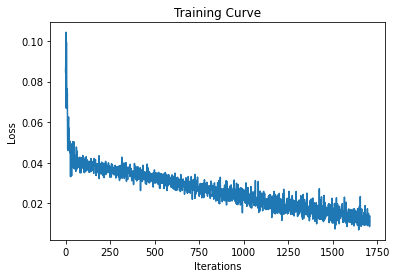

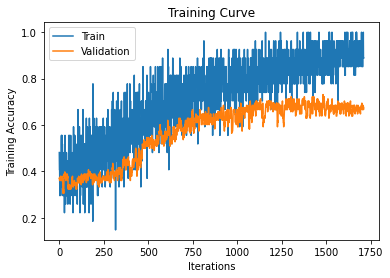

Epoch:  95 Train Accuracy:  0.9279835390946503 Val Accuracy:  0.6851851851851852 Progress:  96.00  % Time Elapsed:  1741.34 s 
Epoch 95 Finished.  Time per Epoch:  18.14 s 
Epoch:  96 Train Accuracy:  0.9279835390946503 Val Accuracy:  0.6574074074074074 Progress:  97.00  % Time Elapsed:  1759.04 s 
Epoch 96 Finished.  Time per Epoch:  18.13 s 
Epoch:  97 Train Accuracy:  0.9320987654320988 Val Accuracy:  0.6759259259259259 Progress:  98.00  % Time Elapsed:  1776.73 s 
Epoch 97 Finished.  Time per Epoch:  18.13 s 
Epoch:  98 Train Accuracy:  0.9279835390946503 Val Accuracy:  0.6851851851851852 Progress:  99.00  % Time Elapsed:  1794.60 s 
Epoch 98 Finished.  Time per Epoch:  18.13 s 
Epoch:  99 Train Accuracy:  0.934156378600823 Val Accuracy:  0.6388888888888888 Progress:  100.00  % Time Elapsed:  1812.42 s 
Epoch 99 Finished.  Time per Epoch:  18.12 s 


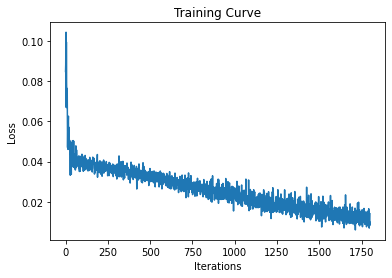

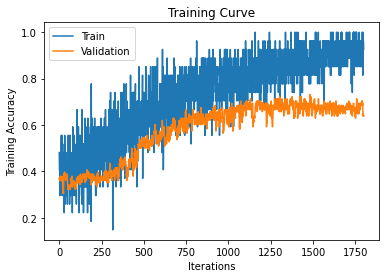

Finished Training
Total time:   1812.75 s  Time per Epoch:  18.13 s 


In [18]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 100
learning_rate = 0.0005
name = "data_ps1and2_gn0.05_new"
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_70_val_accuracy_20bands_with_ps1_gn0.07_V2",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net_4 = CRNN(config)
train_crnn_net(acc_net_4, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 2 - CRNN (RAW)

Dataset: raw_3classes_20bands_10s_npy_CRNN

Augmentation: None 

Architecture: 1 conv layer (32 output, 3 kernel), 50 hidden units, 3 linear layers ( 25 -> 12, 12 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.3786008230452675 Val Accuracy:  0.3425925925925926 Progress:   2.00  % Time Elapsed:   6.02 s 
Epoch 0 Finished.  Time per Epoch:   6.02 s 
Epoch:  1 Train Accuracy:  0.3477366255144033 Val Accuracy:  0.3611111111111111 Progress:   4.00  % Time Elapsed:  12.06 s 
Epoch 1 Finished.  Time per Epoch:   6.03 s 
Epoch:  2 Train Accuracy:  0.3991769547325103 Val Accuracy:  0.3888888888888889 Progress:   6.00  % Time Elapsed:  18.31 s 
Epoch 2 Finished.  Time per Epoch:   6.10 s 
Epoch:  3 Train Accuracy:  0.4156378600823045 Val Accuracy:  0.39814814814814814 Progress:   8.00  % Time Elapsed:  24.34 s 
Epoch 3 Finished.  Time per Epoch:   6.09 s 
Epoch:  4 Train Accuracy:  0.4547325102880658 Val Accuracy:  0.4074074074074074 Progress:  10.00  % Time Elapsed:  30.39 s 
Epoch 4 Finished.  Time per Epoch:   6.08 s 


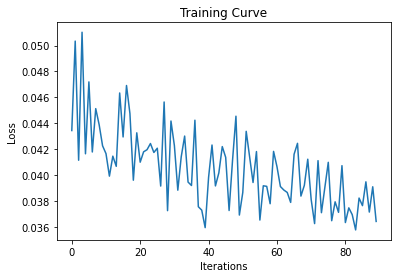

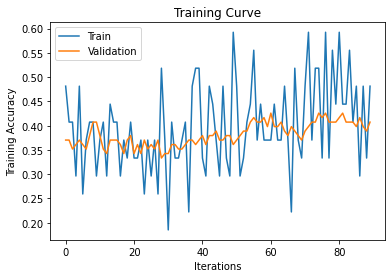

Epoch:  5 Train Accuracy:  0.4691358024691358 Val Accuracy:  0.4166666666666667 Progress:  12.00  % Time Elapsed:  36.62 s 
Epoch 5 Finished.  Time per Epoch:   6.10 s 
Epoch:  6 Train Accuracy:  0.5 Val Accuracy:  0.4537037037037037 Progress:  14.00  % Time Elapsed:  42.59 s 
Epoch 6 Finished.  Time per Epoch:   6.08 s 
Epoch:  7 Train Accuracy:  0.5576131687242798 Val Accuracy:  0.42592592592592593 Progress:  16.00  % Time Elapsed:  48.55 s 
Epoch 7 Finished.  Time per Epoch:   6.07 s 
Epoch:  8 Train Accuracy:  0.551440329218107 Val Accuracy:  0.5 Progress:  18.00  % Time Elapsed:  54.45 s 
Epoch 8 Finished.  Time per Epoch:   6.05 s 
Epoch:  9 Train Accuracy:  0.5761316872427984 Val Accuracy:  0.4722222222222222 Progress:  20.00  % Time Elapsed:  60.52 s 
Epoch 9 Finished.  Time per Epoch:   6.05 s 


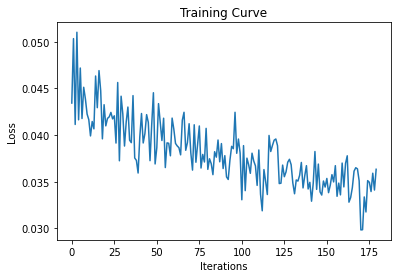

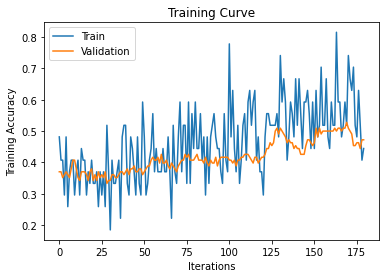

Epoch:  10 Train Accuracy:  0.5843621399176955 Val Accuracy:  0.5277777777777778 Progress:  22.00  % Time Elapsed:  66.87 s 
Epoch 10 Finished.  Time per Epoch:   6.08 s 
Epoch:  11 Train Accuracy:  0.5843621399176955 Val Accuracy:  0.4444444444444444 Progress:  24.00  % Time Elapsed:  72.95 s 
Epoch 11 Finished.  Time per Epoch:   6.08 s 
Epoch:  12 Train Accuracy:  0.6090534979423868 Val Accuracy:  0.5462962962962963 Progress:  26.00  % Time Elapsed:  78.93 s 
Epoch 12 Finished.  Time per Epoch:   6.07 s 
Epoch:  13 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5 Progress:  28.00  % Time Elapsed:  84.88 s 
Epoch 13 Finished.  Time per Epoch:   6.06 s 
Epoch:  14 Train Accuracy:  0.602880658436214 Val Accuracy:  0.5925925925925926 Progress:  30.00  % Time Elapsed:  90.82 s 
Epoch 14 Finished.  Time per Epoch:   6.05 s 


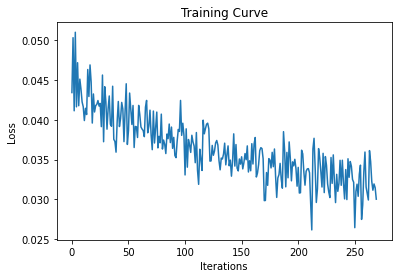

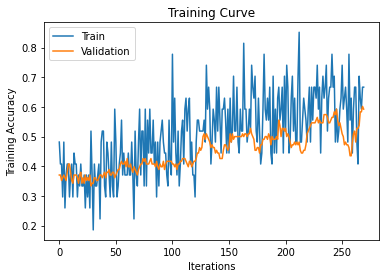

Epoch:  15 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5185185185185185 Progress:  32.00  % Time Elapsed:  97.13 s 
Epoch 15 Finished.  Time per Epoch:   6.07 s 
Epoch:  16 Train Accuracy:  0.6275720164609053 Val Accuracy:  0.5462962962962963 Progress:  34.00  % Time Elapsed:  103.15 s 
Epoch 16 Finished.  Time per Epoch:   6.07 s 
Epoch:  17 Train Accuracy:  0.6481481481481481 Val Accuracy:  0.5925925925925926 Progress:  36.00  % Time Elapsed:  109.22 s 
Epoch 17 Finished.  Time per Epoch:   6.07 s 
Epoch:  18 Train Accuracy:  0.6337448559670782 Val Accuracy:  0.5555555555555556 Progress:  38.00  % Time Elapsed:  115.18 s 
Epoch 18 Finished.  Time per Epoch:   6.06 s 
Epoch:  19 Train Accuracy:  0.6584362139917695 Val Accuracy:  0.5277777777777778 Progress:  40.00  % Time Elapsed:  121.23 s 
Epoch 19 Finished.  Time per Epoch:   6.06 s 


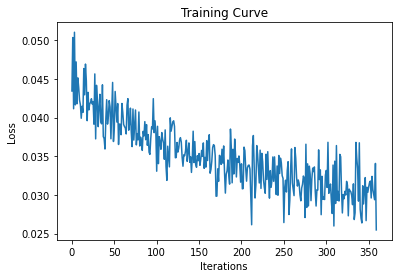

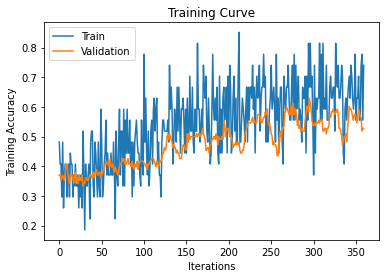

Epoch:  20 Train Accuracy:  0.6481481481481481 Val Accuracy:  0.5185185185185185 Progress:  42.00  % Time Elapsed:  127.52 s 
Epoch 20 Finished.  Time per Epoch:   6.07 s 
Epoch:  21 Train Accuracy:  0.6419753086419753 Val Accuracy:  0.5925925925925926 Progress:  44.00  % Time Elapsed:  133.53 s 
Epoch 21 Finished.  Time per Epoch:   6.07 s 
Epoch:  22 Train Accuracy:  0.6790123456790124 Val Accuracy:  0.5 Progress:  46.00  % Time Elapsed:  139.52 s 
Epoch 22 Finished.  Time per Epoch:   6.07 s 
Epoch:  23 Train Accuracy:  0.6604938271604939 Val Accuracy:  0.5740740740740741 Progress:  48.00  % Time Elapsed:  145.49 s 
Epoch 23 Finished.  Time per Epoch:   6.06 s 
Epoch:  24 Train Accuracy:  0.6872427983539094 Val Accuracy:  0.5648148148148148 Progress:  50.00  % Time Elapsed:  151.78 s 
Epoch 24 Finished.  Time per Epoch:   6.07 s 


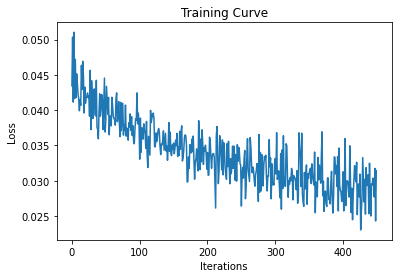

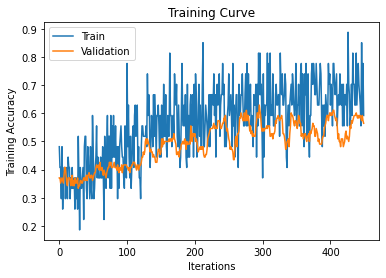

Epoch:  25 Train Accuracy:  0.6728395061728395 Val Accuracy:  0.5648148148148148 Progress:  52.00  % Time Elapsed:  158.59 s 
Epoch 25 Finished.  Time per Epoch:   6.10 s 
Epoch:  26 Train Accuracy:  0.6872427983539094 Val Accuracy:  0.5277777777777778 Progress:  54.00  % Time Elapsed:  164.64 s 
Epoch 26 Finished.  Time per Epoch:   6.10 s 
Epoch:  27 Train Accuracy:  0.668724279835391 Val Accuracy:  0.5648148148148148 Progress:  56.00  % Time Elapsed:  170.60 s 
Epoch 27 Finished.  Time per Epoch:   6.09 s 
Epoch:  28 Train Accuracy:  0.6975308641975309 Val Accuracy:  0.5648148148148148 Progress:  58.00  % Time Elapsed:  176.54 s 
Epoch 28 Finished.  Time per Epoch:   6.09 s 
Epoch:  29 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5462962962962963 Progress:  60.00  % Time Elapsed:  182.51 s 
Epoch 29 Finished.  Time per Epoch:   6.08 s 


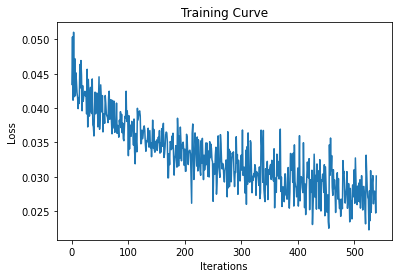

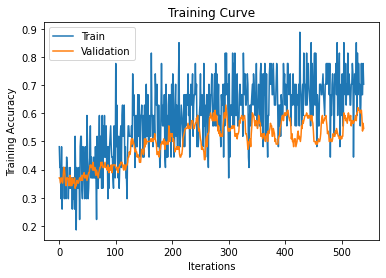

Epoch:  30 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5740740740740741 Progress:  62.00  % Time Elapsed:  188.73 s 
Epoch 30 Finished.  Time per Epoch:   6.09 s 
Epoch:  31 Train Accuracy:  0.6954732510288066 Val Accuracy:  0.5740740740740741 Progress:  64.00  % Time Elapsed:  194.75 s 
Epoch 31 Finished.  Time per Epoch:   6.09 s 
Epoch:  32 Train Accuracy:  0.720164609053498 Val Accuracy:  0.5925925925925926 Progress:  66.00  % Time Elapsed:  200.83 s 
Epoch 32 Finished.  Time per Epoch:   6.09 s 
Epoch:  33 Train Accuracy:  0.6995884773662552 Val Accuracy:  0.5 Progress:  68.00  % Time Elapsed:  206.79 s 
Epoch 33 Finished.  Time per Epoch:   6.08 s 
Epoch:  34 Train Accuracy:  0.7098765432098766 Val Accuracy:  0.6296296296296297 Progress:  70.00  % Time Elapsed:  212.80 s 
Epoch 34 Finished.  Time per Epoch:   6.08 s 


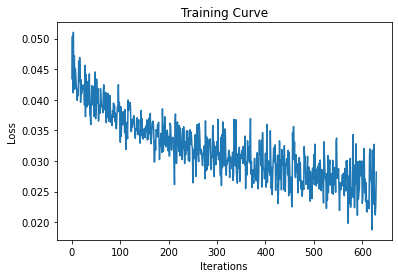

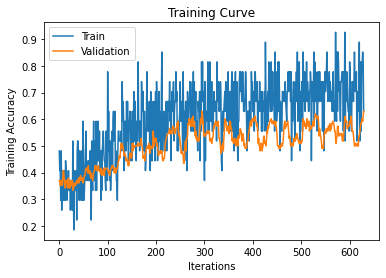

Epoch:  35 Train Accuracy:  0.7345679012345679 Val Accuracy:  0.5833333333333334 Progress:  72.00  % Time Elapsed:  219.20 s 
Epoch 35 Finished.  Time per Epoch:   6.09 s 
Epoch:  36 Train Accuracy:  0.7489711934156379 Val Accuracy:  0.5740740740740741 Progress:  74.00  % Time Elapsed:  225.27 s 
Epoch 36 Finished.  Time per Epoch:   6.09 s 
Epoch:  37 Train Accuracy:  0.7304526748971193 Val Accuracy:  0.6111111111111112 Progress:  76.00  % Time Elapsed:  231.31 s 
Epoch 37 Finished.  Time per Epoch:   6.09 s 
Epoch:  38 Train Accuracy:  0.7654320987654321 Val Accuracy:  0.6111111111111112 Progress:  78.00  % Time Elapsed:  237.31 s 
Epoch 38 Finished.  Time per Epoch:   6.08 s 
Epoch:  39 Train Accuracy:  0.7818930041152263 Val Accuracy:  0.5277777777777778 Progress:  80.00  % Time Elapsed:  243.20 s 
Epoch 39 Finished.  Time per Epoch:   6.08 s 


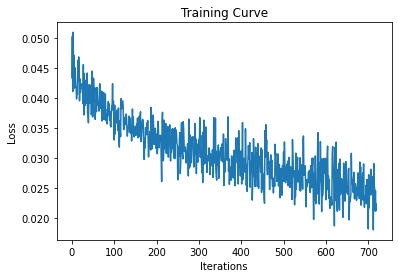

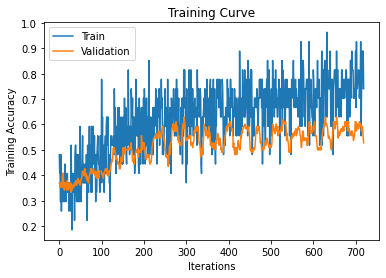

Epoch:  40 Train Accuracy:  0.7757201646090535 Val Accuracy:  0.5833333333333334 Progress:  82.00  % Time Elapsed:  249.54 s 
Epoch 40 Finished.  Time per Epoch:   6.09 s 
Epoch:  41 Train Accuracy:  0.7592592592592593 Val Accuracy:  0.5833333333333334 Progress:  84.00  % Time Elapsed:  255.53 s 
Epoch 41 Finished.  Time per Epoch:   6.08 s 
Epoch:  42 Train Accuracy:  0.7654320987654321 Val Accuracy:  0.5833333333333334 Progress:  86.00  % Time Elapsed:  261.47 s 
Epoch 42 Finished.  Time per Epoch:   6.08 s 
Epoch:  43 Train Accuracy:  0.7818930041152263 Val Accuracy:  0.5648148148148148 Progress:  88.00  % Time Elapsed:  267.45 s 
Epoch 43 Finished.  Time per Epoch:   6.08 s 
Epoch:  44 Train Accuracy:  0.7736625514403292 Val Accuracy:  0.5925925925925926 Progress:  90.00  % Time Elapsed:  273.45 s 
Epoch 44 Finished.  Time per Epoch:   6.08 s 


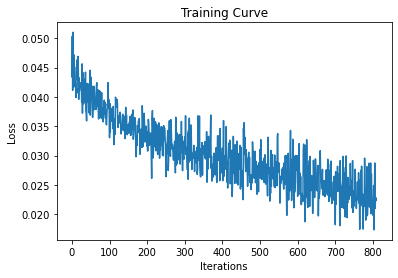

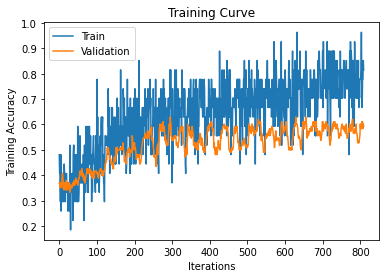

Epoch:  45 Train Accuracy:  0.779835390946502 Val Accuracy:  0.5740740740740741 Progress:  92.00  % Time Elapsed:  279.73 s 
Epoch 45 Finished.  Time per Epoch:   6.08 s 
Epoch:  46 Train Accuracy:  0.7942386831275721 Val Accuracy:  0.5555555555555556 Progress:  94.00  % Time Elapsed:  285.68 s 
Epoch 46 Finished.  Time per Epoch:   6.08 s 
Epoch:  47 Train Accuracy:  0.8004115226337448 Val Accuracy:  0.5833333333333334 Progress:  96.00  % Time Elapsed:  291.63 s 
Epoch 47 Finished.  Time per Epoch:   6.08 s 
Epoch:  48 Train Accuracy:  0.7942386831275721 Val Accuracy:  0.5740740740740741 Progress:  98.00  % Time Elapsed:  297.67 s 
Epoch 48 Finished.  Time per Epoch:   6.07 s 
Epoch:  49 Train Accuracy:  0.8106995884773662 Val Accuracy:  0.5462962962962963 Progress:  100.00  % Time Elapsed:  303.67 s 
Epoch 49 Finished.  Time per Epoch:   6.07 s 


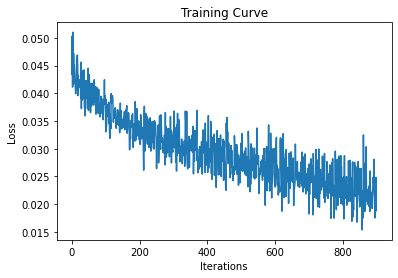

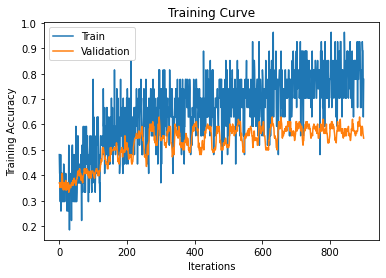

Finished Training
Total time:   303.97 s  Time per Epoch:   6.08 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_best_raw_10s_20bands",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net_4 = CRNN(config)
train_crnn_net(acc_net_4, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 3 - CRNN: Previous Split 

Dataset: raw_10s_3classes_npy

Augmentation: "ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy" 

Architecture: 1 conv layer (16,32 output, 3 kernel), 50 hidden units, 3 linear layers ( 20 -> 10, 10 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [19]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Epoch:  0 Train Accuracy:  0.2657952069716776 Val Accuracy:  0.37037037037037035 Progress:   2.00  % Time Elapsed:  95.72 s 
Epoch 0 Finished.  Time per Epoch:  95.72 s 
Epoch:  1 Train Accuracy:  0.37037037037037035 Val Accuracy:  0.37037037037037035 Progress:   4.00  % Time Elapsed:  103.73 s 
Epoch 1 Finished.  Time per Epoch:  51.86 s 
Epoch:  2 Train Accuracy:  0.4095860566448802 Val Accuracy:  0.4444444444444444 Progress:   6.00  % Time Elapsed:  110.62 s 
Epoch 2 Finished.  Time per Epoch:  36.87 s 
Epoch:  3 Train Accuracy:  0.43137254901960786 Val Accuracy:  0.2777777777777778 Progress:   8.00  % Time Elapsed:  117.49 s 
Epoch 3 Finished.  Time per Epoch:  29.37 s 
Epoch:  4 Train Accuracy:  0.4531590413943355 Val Accuracy:  0.3148148148148148 Progress:  10.00  % Time Elapsed:  124.34 s 
Epoch 4 Finished.  Time per Epoch:  24.87 s 
Epoch:  5 Train Accuracy:  0.47276688453159044 Val Accuracy:  0.24074074074074073 Progress:  12.00  % Time Elapsed:  131.27 s 
Epoch 5 Finished.  T

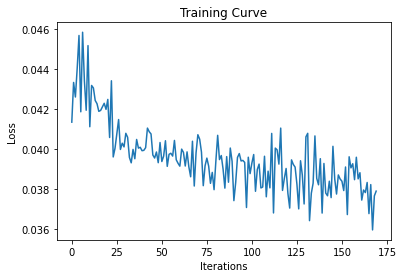

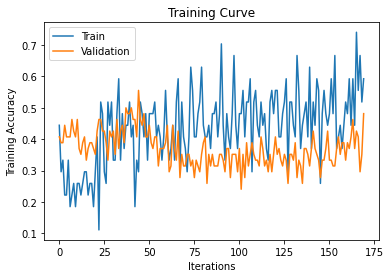

Epoch:  10 Train Accuracy:  0.5054466230936819 Val Accuracy:  0.37037037037037035 Progress:  22.00  % Time Elapsed:  166.14 s 
Epoch 10 Finished.  Time per Epoch:  15.10 s 
Epoch:  11 Train Accuracy:  0.5163398692810458 Val Accuracy:  0.3888888888888889 Progress:  24.00  % Time Elapsed:  173.09 s 
Epoch 11 Finished.  Time per Epoch:  14.42 s 
Epoch:  12 Train Accuracy:  0.5272331154684096 Val Accuracy:  0.4444444444444444 Progress:  26.00  % Time Elapsed:  180.01 s 
Epoch 12 Finished.  Time per Epoch:  13.85 s 
Epoch:  13 Train Accuracy:  0.5206971677559913 Val Accuracy:  0.42592592592592593 Progress:  28.00  % Time Elapsed:  186.98 s 
Epoch 13 Finished.  Time per Epoch:  13.36 s 
Epoch:  14 Train Accuracy:  0.5446623093681917 Val Accuracy:  0.3888888888888889 Progress:  30.00  % Time Elapsed:  193.85 s 
Epoch 14 Finished.  Time per Epoch:  12.92 s 
Epoch:  15 Train Accuracy:  0.5403050108932462 Val Accuracy:  0.5370370370370371 Progress:  32.00  % Time Elapsed:  200.68 s 
Epoch 15 Fin

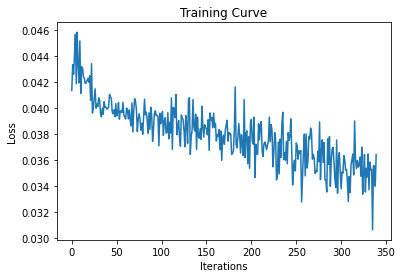

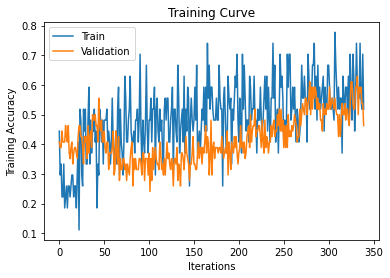

Epoch:  20 Train Accuracy:  0.5904139433551199 Val Accuracy:  0.5370370370370371 Progress:  42.00  % Time Elapsed:  235.79 s 
Epoch 20 Finished.  Time per Epoch:  11.23 s 
Epoch:  21 Train Accuracy:  0.5947712418300654 Val Accuracy:  0.5925925925925926 Progress:  44.00  % Time Elapsed:  242.79 s 
Epoch 21 Finished.  Time per Epoch:  11.04 s 
Epoch:  22 Train Accuracy:  0.6361655773420479 Val Accuracy:  0.5555555555555556 Progress:  46.00  % Time Elapsed:  249.73 s 
Epoch 22 Finished.  Time per Epoch:  10.86 s 
Epoch:  23 Train Accuracy:  0.6078431372549019 Val Accuracy:  0.5925925925925926 Progress:  48.00  % Time Elapsed:  257.33 s 
Epoch 23 Finished.  Time per Epoch:  10.72 s 
Epoch:  24 Train Accuracy:  0.6514161220043573 Val Accuracy:  0.5555555555555556 Progress:  50.00  % Time Elapsed:  264.31 s 
Epoch 24 Finished.  Time per Epoch:  10.57 s 
Epoch:  25 Train Accuracy:  0.6274509803921569 Val Accuracy:  0.5370370370370371 Progress:  52.00  % Time Elapsed:  271.24 s 
Epoch 25 Finis

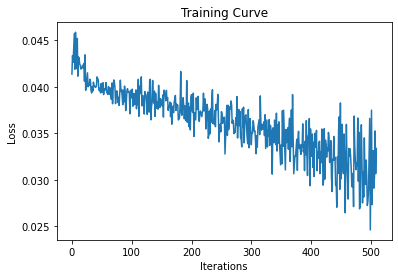

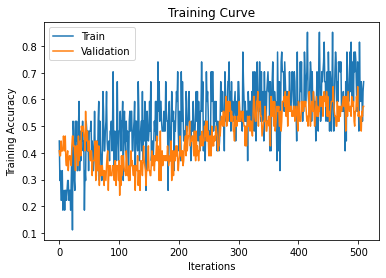

Epoch:  30 Train Accuracy:  0.6688453159041394 Val Accuracy:  0.7037037037037037 Progress:  62.00  % Time Elapsed:  306.40 s 
Epoch 30 Finished.  Time per Epoch:   9.88 s 
Epoch:  31 Train Accuracy:  0.6623093681917211 Val Accuracy:  0.6111111111111112 Progress:  64.00  % Time Elapsed:  313.35 s 
Epoch 31 Finished.  Time per Epoch:   9.79 s 
Epoch:  32 Train Accuracy:  0.6949891067538126 Val Accuracy:  0.6481481481481481 Progress:  66.00  % Time Elapsed:  320.29 s 
Epoch 32 Finished.  Time per Epoch:   9.71 s 
Epoch:  33 Train Accuracy:  0.6710239651416122 Val Accuracy:  0.5185185185185185 Progress:  68.00  % Time Elapsed:  327.31 s 
Epoch 33 Finished.  Time per Epoch:   9.63 s 
Epoch:  34 Train Accuracy:  0.6840958605664488 Val Accuracy:  0.5185185185185185 Progress:  70.00  % Time Elapsed:  334.33 s 
Epoch 34 Finished.  Time per Epoch:   9.55 s 
Epoch:  35 Train Accuracy:  0.6862745098039216 Val Accuracy:  0.5555555555555556 Progress:  72.00  % Time Elapsed:  341.46 s 
Epoch 35 Finis

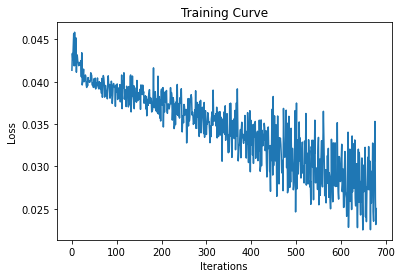

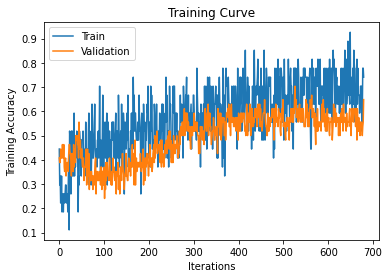

Epoch:  40 Train Accuracy:  0.7015250544662309 Val Accuracy:  0.5925925925925926 Progress:  82.00  % Time Elapsed:  376.83 s 
Epoch 40 Finished.  Time per Epoch:   9.19 s 
Epoch:  41 Train Accuracy:  0.7211328976034859 Val Accuracy:  0.5555555555555556 Progress:  84.00  % Time Elapsed:  384.07 s 
Epoch 41 Finished.  Time per Epoch:   9.14 s 
Epoch:  42 Train Accuracy:  0.7211328976034859 Val Accuracy:  0.6296296296296297 Progress:  86.00  % Time Elapsed:  391.48 s 
Epoch 42 Finished.  Time per Epoch:   9.10 s 
Epoch:  43 Train Accuracy:  0.7167755991285403 Val Accuracy:  0.5925925925925926 Progress:  88.00  % Time Elapsed:  398.97 s 
Epoch 43 Finished.  Time per Epoch:   9.07 s 
Epoch:  44 Train Accuracy:  0.7233115468409586 Val Accuracy:  0.5555555555555556 Progress:  90.00  % Time Elapsed:  406.27 s 
Epoch 44 Finished.  Time per Epoch:   9.03 s 
Epoch:  45 Train Accuracy:  0.7211328976034859 Val Accuracy:  0.5370370370370371 Progress:  92.00  % Time Elapsed:  413.17 s 
Epoch 45 Finis

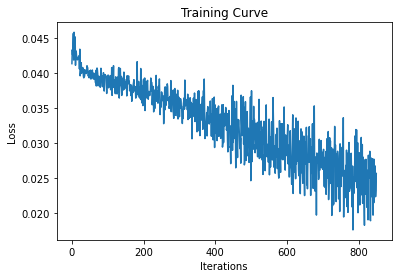

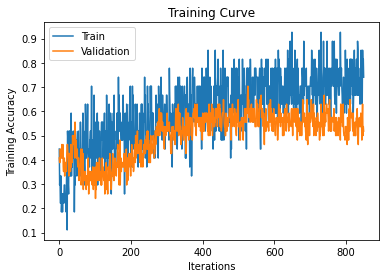

Finished Training
Total time:   441.77 s  Time per Epoch:   8.84 s 


In [27]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_best_raw_10s_20bands",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 4 - CRNN 20 bands with only gaussian noise

Dataset: raw_3classes_20bands_10s_npy_CRNN

Augmentation: "raw_3classes_20bands_10s_npy_CRNN_augmented_ps1",
                         "3classes_20bands_10s_npy_CRNN_augmented_gn0.07

Architecture: 1 conv layer (32 output, 3 kernel), 50 hidden units, 3 linear layers ( 25 -> 12, 12 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50 

In [27]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 25),
                                nn.Linear(25,12),
                            nn.Linear(12, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Epoch:  0 Train Accuracy:  0.35390946502057613 Val Accuracy:  0.4166666666666667 Progress:   2.00  % Time Elapsed:  20.94 s 
Epoch 0 Finished.  Time per Epoch:  20.94 s 
Epoch:  1 Train Accuracy:  0.4176954732510288 Val Accuracy:  0.37962962962962965 Progress:   4.00  % Time Elapsed:  44.03 s 
Epoch 1 Finished.  Time per Epoch:  22.02 s 
Epoch:  2 Train Accuracy:  0.4279835390946502 Val Accuracy:  0.37037037037037035 Progress:   6.00  % Time Elapsed:  65.38 s 
Epoch 2 Finished.  Time per Epoch:  21.79 s 
Epoch:  3 Train Accuracy:  0.42386831275720166 Val Accuracy:  0.4444444444444444 Progress:   8.00  % Time Elapsed:  86.50 s 
Epoch 3 Finished.  Time per Epoch:  21.63 s 
Epoch:  4 Train Accuracy:  0.4609053497942387 Val Accuracy:  0.42592592592592593 Progress:  10.00  % Time Elapsed:  107.82 s 
Epoch 4 Finished.  Time per Epoch:  21.56 s 


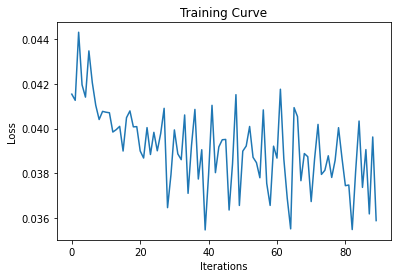

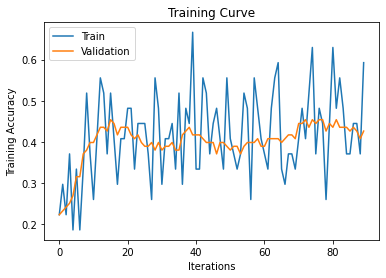

Epoch:  5 Train Accuracy:  0.4506172839506173 Val Accuracy:  0.4074074074074074 Progress:  12.00  % Time Elapsed:  129.54 s 
Epoch 5 Finished.  Time per Epoch:  21.59 s 
Epoch:  6 Train Accuracy:  0.4691358024691358 Val Accuracy:  0.4166666666666667 Progress:  14.00  % Time Elapsed:  150.86 s 
Epoch 6 Finished.  Time per Epoch:  21.55 s 
Epoch:  7 Train Accuracy:  0.48148148148148145 Val Accuracy:  0.39814814814814814 Progress:  16.00  % Time Elapsed:  172.29 s 
Epoch 7 Finished.  Time per Epoch:  21.54 s 
Epoch:  8 Train Accuracy:  0.4835390946502058 Val Accuracy:  0.37962962962962965 Progress:  18.00  % Time Elapsed:  193.95 s 
Epoch 8 Finished.  Time per Epoch:  21.55 s 
Epoch:  9 Train Accuracy:  0.4711934156378601 Val Accuracy:  0.4074074074074074 Progress:  20.00  % Time Elapsed:  215.45 s 
Epoch 9 Finished.  Time per Epoch:  21.55 s 


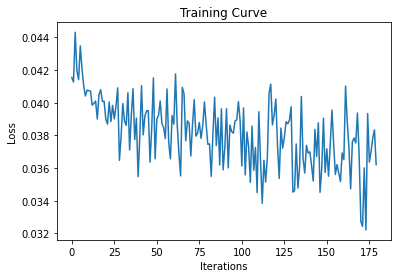

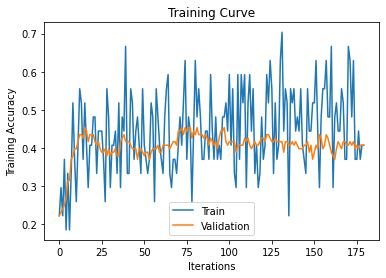

Epoch:  10 Train Accuracy:  0.5041152263374485 Val Accuracy:  0.37962962962962965 Progress:  22.00  % Time Elapsed:  237.33 s 
Epoch 10 Finished.  Time per Epoch:  21.58 s 
Epoch:  11 Train Accuracy:  0.49794238683127573 Val Accuracy:  0.39814814814814814 Progress:  24.00  % Time Elapsed:  258.72 s 
Epoch 11 Finished.  Time per Epoch:  21.56 s 
Epoch:  12 Train Accuracy:  0.5370370370370371 Val Accuracy:  0.42592592592592593 Progress:  26.00  % Time Elapsed:  280.30 s 
Epoch 12 Finished.  Time per Epoch:  21.56 s 
Epoch:  13 Train Accuracy:  0.5679012345679012 Val Accuracy:  0.37037037037037035 Progress:  28.00  % Time Elapsed:  301.95 s 
Epoch 13 Finished.  Time per Epoch:  21.57 s 
Epoch:  14 Train Accuracy:  0.5473251028806584 Val Accuracy:  0.4537037037037037 Progress:  30.00  % Time Elapsed:  324.77 s 
Epoch 14 Finished.  Time per Epoch:  21.65 s 


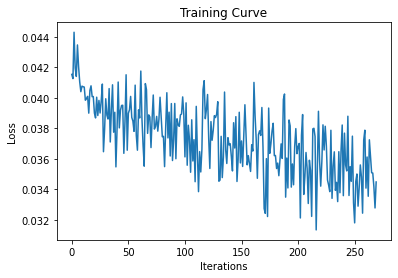

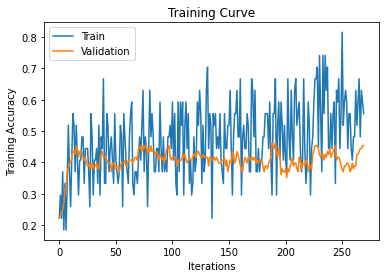

Epoch:  15 Train Accuracy:  0.5679012345679012 Val Accuracy:  0.4166666666666667 Progress:  32.00  % Time Elapsed:  346.99 s 
Epoch 15 Finished.  Time per Epoch:  21.69 s 
Epoch:  16 Train Accuracy:  0.5823045267489712 Val Accuracy:  0.4537037037037037 Progress:  34.00  % Time Elapsed:  368.80 s 
Epoch 16 Finished.  Time per Epoch:  21.69 s 
Epoch:  17 Train Accuracy:  0.5987654320987654 Val Accuracy:  0.49074074074074076 Progress:  36.00  % Time Elapsed:  390.86 s 
Epoch 17 Finished.  Time per Epoch:  21.71 s 
Epoch:  18 Train Accuracy:  0.6049382716049383 Val Accuracy:  0.5 Progress:  38.00  % Time Elapsed:  412.72 s 
Epoch 18 Finished.  Time per Epoch:  21.72 s 
Epoch:  19 Train Accuracy:  0.6646090534979424 Val Accuracy:  0.5277777777777778 Progress:  40.00  % Time Elapsed:  434.32 s 
Epoch 19 Finished.  Time per Epoch:  21.72 s 


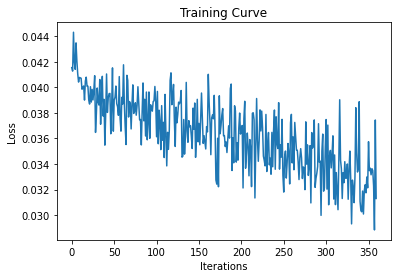

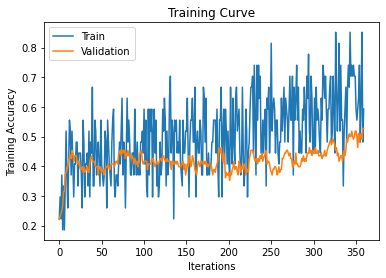

Epoch:  20 Train Accuracy:  0.6460905349794238 Val Accuracy:  0.5092592592592593 Progress:  42.00  % Time Elapsed:  456.32 s 
Epoch 20 Finished.  Time per Epoch:  21.73 s 
Epoch:  21 Train Accuracy:  0.6419753086419753 Val Accuracy:  0.5092592592592593 Progress:  44.00  % Time Elapsed:  477.93 s 
Epoch 21 Finished.  Time per Epoch:  21.72 s 
Epoch:  22 Train Accuracy:  0.6851851851851852 Val Accuracy:  0.5092592592592593 Progress:  46.00  % Time Elapsed:  500.41 s 
Epoch 22 Finished.  Time per Epoch:  21.76 s 
Epoch:  23 Train Accuracy:  0.6522633744855967 Val Accuracy:  0.5555555555555556 Progress:  48.00  % Time Elapsed:  522.10 s 
Epoch 23 Finished.  Time per Epoch:  21.75 s 
Epoch:  24 Train Accuracy:  0.6893004115226338 Val Accuracy:  0.5462962962962963 Progress:  50.00  % Time Elapsed:  543.57 s 
Epoch 24 Finished.  Time per Epoch:  21.74 s 


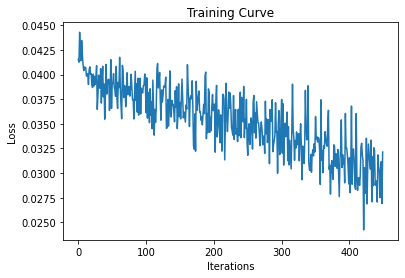

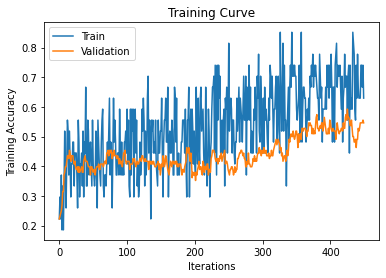

Epoch:  25 Train Accuracy:  0.6460905349794238 Val Accuracy:  0.5833333333333334 Progress:  52.00  % Time Elapsed:  565.39 s 
Epoch 25 Finished.  Time per Epoch:  21.75 s 
Epoch:  26 Train Accuracy:  0.6831275720164609 Val Accuracy:  0.5462962962962963 Progress:  54.00  % Time Elapsed:  586.77 s 
Epoch 26 Finished.  Time per Epoch:  21.73 s 
Epoch:  27 Train Accuracy:  0.6831275720164609 Val Accuracy:  0.5370370370370371 Progress:  56.00  % Time Elapsed:  608.25 s 
Epoch 27 Finished.  Time per Epoch:  21.72 s 
Epoch:  28 Train Accuracy:  0.7057613168724279 Val Accuracy:  0.5740740740740741 Progress:  58.00  % Time Elapsed:  629.98 s 
Epoch 28 Finished.  Time per Epoch:  21.72 s 
Epoch:  29 Train Accuracy:  0.7345679012345679 Val Accuracy:  0.5370370370370371 Progress:  60.00  % Time Elapsed:  652.05 s 
Epoch 29 Finished.  Time per Epoch:  21.73 s 


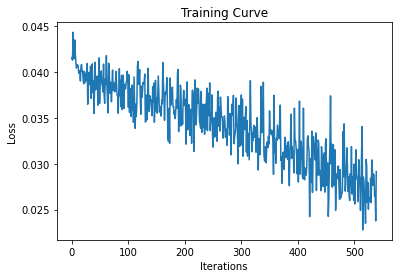

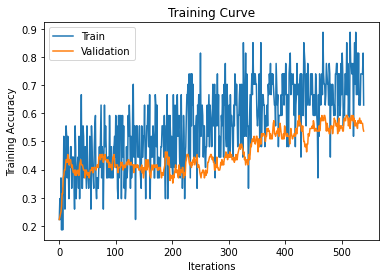

Epoch:  30 Train Accuracy:  0.7037037037037037 Val Accuracy:  0.5370370370370371 Progress:  62.00  % Time Elapsed:  673.91 s 
Epoch 30 Finished.  Time per Epoch:  21.74 s 
Epoch:  31 Train Accuracy:  0.7139917695473251 Val Accuracy:  0.5740740740740741 Progress:  64.00  % Time Elapsed:  695.26 s 
Epoch 31 Finished.  Time per Epoch:  21.73 s 
Epoch:  32 Train Accuracy:  0.742798353909465 Val Accuracy:  0.5740740740740741 Progress:  66.00  % Time Elapsed:  716.58 s 
Epoch 32 Finished.  Time per Epoch:  21.71 s 
Epoch:  33 Train Accuracy:  0.7119341563786008 Val Accuracy:  0.5462962962962963 Progress:  68.00  % Time Elapsed:  738.29 s 
Epoch 33 Finished.  Time per Epoch:  21.71 s 
Epoch:  34 Train Accuracy:  0.7489711934156379 Val Accuracy:  0.5740740740740741 Progress:  70.00  % Time Elapsed:  759.82 s 
Epoch 34 Finished.  Time per Epoch:  21.71 s 


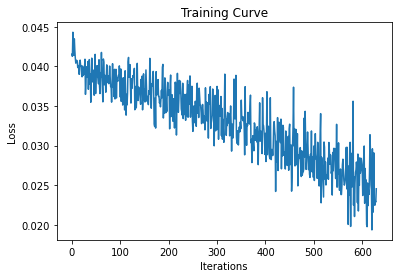

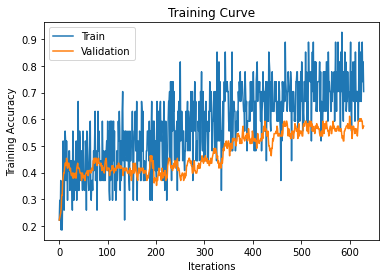

Epoch:  35 Train Accuracy:  0.7530864197530864 Val Accuracy:  0.5648148148148148 Progress:  72.00  % Time Elapsed:  781.72 s 
Epoch 35 Finished.  Time per Epoch:  21.71 s 
Epoch:  36 Train Accuracy:  0.7592592592592593 Val Accuracy:  0.6111111111111112 Progress:  74.00  % Time Elapsed:  803.57 s 
Epoch 36 Finished.  Time per Epoch:  21.72 s 
Epoch:  37 Train Accuracy:  0.7757201646090535 Val Accuracy:  0.5740740740740741 Progress:  76.00  % Time Elapsed:  825.08 s 
Epoch 37 Finished.  Time per Epoch:  21.71 s 
Epoch:  38 Train Accuracy:  0.7736625514403292 Val Accuracy:  0.5740740740740741 Progress:  78.00  % Time Elapsed:  846.49 s 
Epoch 38 Finished.  Time per Epoch:  21.70 s 
Epoch:  39 Train Accuracy:  0.7901234567901234 Val Accuracy:  0.5833333333333334 Progress:  80.00  % Time Elapsed:  867.91 s 
Epoch 39 Finished.  Time per Epoch:  21.70 s 


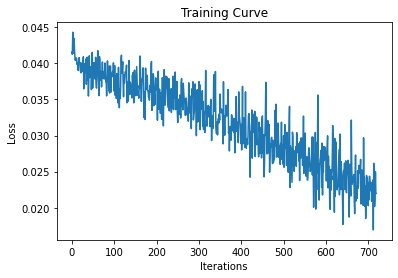

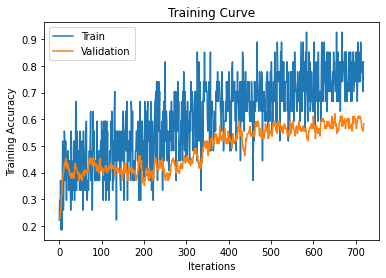

Epoch:  40 Train Accuracy:  0.779835390946502 Val Accuracy:  0.5833333333333334 Progress:  82.00  % Time Elapsed:  889.73 s 
Epoch 40 Finished.  Time per Epoch:  21.70 s 
Epoch:  41 Train Accuracy:  0.7983539094650206 Val Accuracy:  0.5925925925925926 Progress:  84.00  % Time Elapsed:  911.04 s 
Epoch 41 Finished.  Time per Epoch:  21.69 s 
Epoch:  42 Train Accuracy:  0.7921810699588477 Val Accuracy:  0.6018518518518519 Progress:  86.00  % Time Elapsed:  932.49 s 
Epoch 42 Finished.  Time per Epoch:  21.69 s 
Epoch:  43 Train Accuracy:  0.808641975308642 Val Accuracy:  0.6111111111111112 Progress:  88.00  % Time Elapsed:  954.50 s 
Epoch 43 Finished.  Time per Epoch:  21.69 s 
Epoch:  44 Train Accuracy:  0.8106995884773662 Val Accuracy:  0.5740740740740741 Progress:  90.00  % Time Elapsed:  976.57 s 
Epoch 44 Finished.  Time per Epoch:  21.70 s 


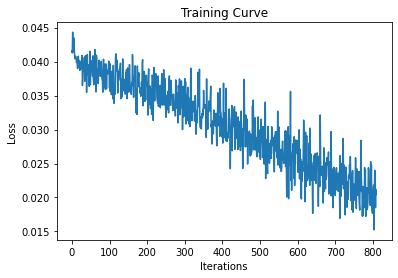

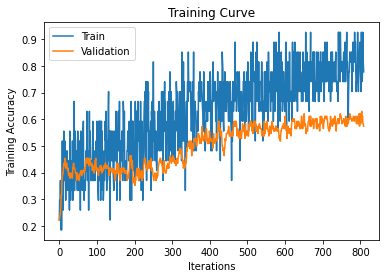

Epoch:  45 Train Accuracy:  0.808641975308642 Val Accuracy:  0.5925925925925926 Progress:  92.00  % Time Elapsed:  998.43 s 
Epoch 45 Finished.  Time per Epoch:  21.70 s 
Epoch:  46 Train Accuracy:  0.8168724279835391 Val Accuracy:  0.5740740740740741 Progress:  94.00  % Time Elapsed:  1019.88 s 
Epoch 46 Finished.  Time per Epoch:  21.70 s 
Epoch:  47 Train Accuracy:  0.8374485596707819 Val Accuracy:  0.5555555555555556 Progress:  96.00  % Time Elapsed:  1041.25 s 
Epoch 47 Finished.  Time per Epoch:  21.69 s 
Epoch:  48 Train Accuracy:  0.831275720164609 Val Accuracy:  0.5462962962962963 Progress:  98.00  % Time Elapsed:  1062.82 s 
Epoch 48 Finished.  Time per Epoch:  21.69 s 
Epoch:  49 Train Accuracy:  0.8477366255144033 Val Accuracy:  0.6018518518518519 Progress:  100.00  % Time Elapsed:  1084.25 s 
Epoch 49 Finished.  Time per Epoch:  21.69 s 


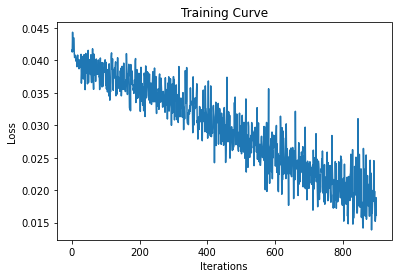

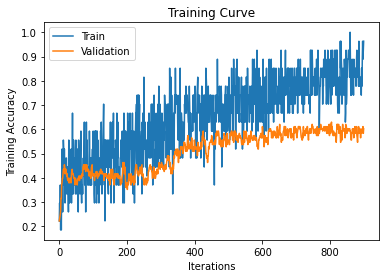

Finished Training
Total time:   1085.07 s  Time per Epoch:  21.70 s 


In [29]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005
name = "data_ps1and2_gn0.05_new"
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_70_val_accuracy_20bands_with_gn0.07",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}

acc_net_4 = CRNN(config)
train_crnn_net(acc_net_4, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 5 - CRNN with 2 Conv layers previous split (EMI) 

Dataset: raw_10s_3classes_npy

Augmentation: None

Architecture: 1 conv layer (16,32 output, 3 kernel), 50 hidden units, 3 linear layers ( 20 -> 10, 10 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [8]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.38344226579520696 Val Accuracy:  0.37037037037037035 Progress:   2.00  % Time Elapsed:   3.56 s 
Epoch 0 Finished.  Time per Epoch:   3.56 s 
Epoch:  1 Train Accuracy:  0.45098039215686275 Val Accuracy:  0.3333333333333333 Progress:   4.00  % Time Elapsed:   7.23 s 
Epoch 1 Finished.  Time per Epoch:   3.61 s 
Epoch:  2 Train Accuracy:  0.4357298474945534 Val Accuracy:  0.35185185185185186 Progress:   6.00  % Time Elapsed:  11.01 s 
Epoch 2 Finished.  Time per Epoch:   3.67 s 
Epoch:  3 Train Accuracy:  0.5294117647058824 Val Accuracy:  0.3888888888888889 Progress:   8.00  % Time Elapsed:  14.68 s 
Epoch 3 Finished.  Time per Epoch:   3.67 s 
Epoch:  4 Train Accuracy:  0.5206971677559913 Val Accuracy:  0.42592592592592593 Progress:  10.00  % Time Elapsed:  18.31 s 
Epoch 4 Finished.  Time per Epoch:   3.66 s 
Epoch:  5 Train Accuracy:  0.5860566448801743 Val Accuracy:  0.5370370370370371 Progress:  12.00  % Time Elapsed:  21.92 s 
Epoch 5 Finishe

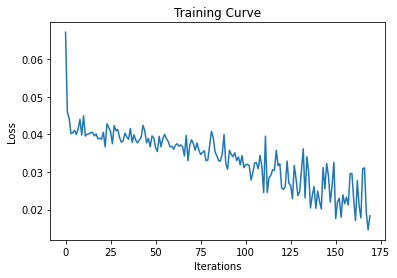

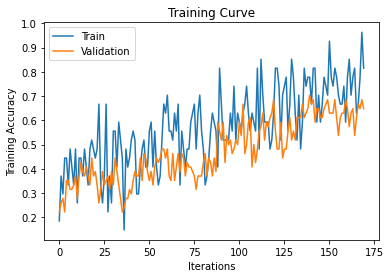

Epoch:  10 Train Accuracy:  0.7930283224400871 Val Accuracy:  0.6851851851851852 Progress:  22.00  % Time Elapsed:  40.28 s 
Epoch 10 Finished.  Time per Epoch:   3.66 s 
Epoch:  11 Train Accuracy:  0.7821350762527233 Val Accuracy:  0.6851851851851852 Progress:  24.00  % Time Elapsed:  43.81 s 
Epoch 11 Finished.  Time per Epoch:   3.65 s 
Epoch:  12 Train Accuracy:  0.8366013071895425 Val Accuracy:  0.7222222222222222 Progress:  26.00  % Time Elapsed:  47.50 s 
Epoch 12 Finished.  Time per Epoch:   3.65 s 
Epoch:  13 Train Accuracy:  0.8671023965141612 Val Accuracy:  0.7222222222222222 Progress:  28.00  % Time Elapsed:  51.11 s 
Epoch 13 Finished.  Time per Epoch:   3.65 s 
Epoch:  14 Train Accuracy:  0.8910675381263616 Val Accuracy:  0.7407407407407407 Progress:  30.00  % Time Elapsed:  54.76 s 
Epoch 14 Finished.  Time per Epoch:   3.65 s 
Epoch:  15 Train Accuracy:  0.9150326797385621 Val Accuracy:  0.7222222222222222 Progress:  32.00  % Time Elapsed:  58.39 s 
Epoch 15 Finished.  

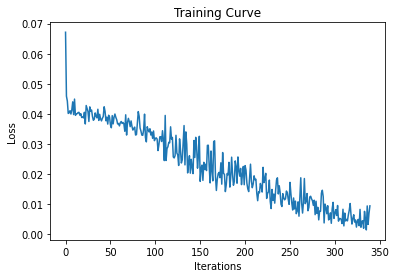

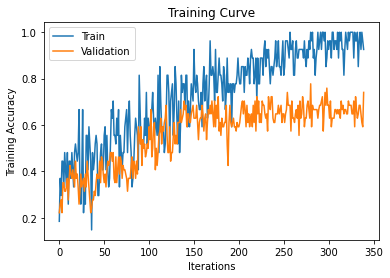

Epoch:  20 Train Accuracy:  0.9825708061002179 Val Accuracy:  0.6481481481481481 Progress:  42.00  % Time Elapsed:  77.56 s 
Epoch 20 Finished.  Time per Epoch:   3.69 s 
Epoch:  21 Train Accuracy:  0.9934640522875817 Val Accuracy:  0.6111111111111112 Progress:  44.00  % Time Elapsed:  82.63 s 
Epoch 21 Finished.  Time per Epoch:   3.76 s 
Epoch:  22 Train Accuracy:  0.9956427015250545 Val Accuracy:  0.7037037037037037 Progress:  46.00  % Time Elapsed:  87.81 s 
Epoch 22 Finished.  Time per Epoch:   3.82 s 
Epoch:  23 Train Accuracy:  0.9956427015250545 Val Accuracy:  0.7962962962962963 Progress:  48.00  % Time Elapsed:  92.68 s 
Epoch 23 Finished.  Time per Epoch:   3.86 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.5740740740740741 Progress:  50.00  % Time Elapsed:  97.47 s 
Epoch 24 Finished.  Time per Epoch:   3.90 s 
Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  52.00  % Time Elapsed:  102.05 s 
Epoch 25 Finished.  Time per Epoch:   3.92 s 
Epo

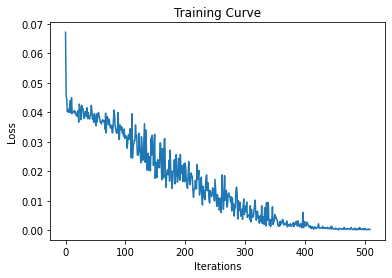

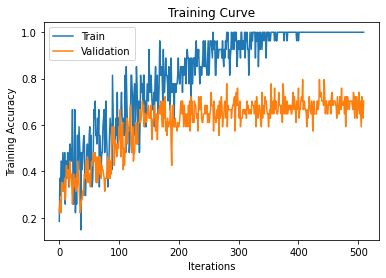

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  62.00  % Time Elapsed:  125.43 s 
Epoch 30 Finished.  Time per Epoch:   4.05 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  64.00  % Time Elapsed:  129.19 s 
Epoch 31 Finished.  Time per Epoch:   4.04 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  66.00  % Time Elapsed:  132.77 s 
Epoch 32 Finished.  Time per Epoch:   4.02 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  68.00  % Time Elapsed:  136.41 s 
Epoch 33 Finished.  Time per Epoch:   4.01 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.5740740740740741 Progress:  70.00  % Time Elapsed:  140.04 s 
Epoch 34 Finished.  Time per Epoch:   4.00 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  72.00  % Time Elapsed:  143.72 s 
Epoch 35 Finished.  Time per Epoch:   3.99 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.722222222

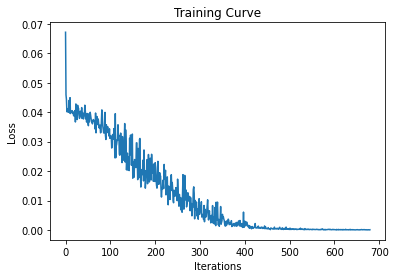

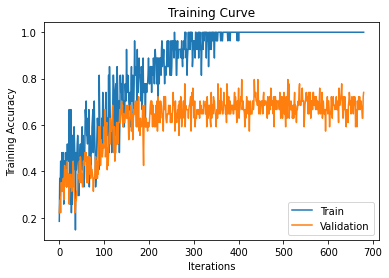

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  82.00  % Time Elapsed:  161.89 s 
Epoch 40 Finished.  Time per Epoch:   3.95 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  84.00  % Time Elapsed:  165.49 s 
Epoch 41 Finished.  Time per Epoch:   3.94 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.7777777777777778 Progress:  86.00  % Time Elapsed:  169.06 s 
Epoch 42 Finished.  Time per Epoch:   3.93 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  88.00  % Time Elapsed:  172.84 s 
Epoch 43 Finished.  Time per Epoch:   3.93 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6111111111111112 Progress:  90.00  % Time Elapsed:  176.54 s 
Epoch 44 Finished.  Time per Epoch:   3.92 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  92.00  % Time Elapsed:  180.04 s 
Epoch 45 Finished.  Time per Epoch:   3.91 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.666666666

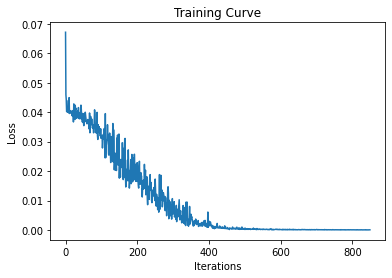

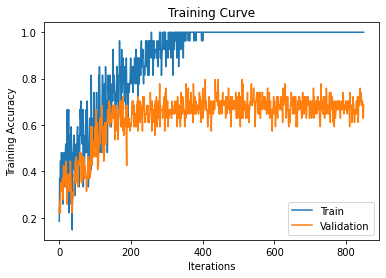

Finished Training
Total time:   194.96 s  Time per Epoch:   3.90 s 


In [12]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_mixed_data_EMI_3classes",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 6 - CRNN previous split w/ more augmentation

Dataset: raw_10s_3classes_npy

Augmentation: "ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy" 

Architecture: 2 conv layer (16,32 output, 3 kernel), 50 hidden units, 3 linear layers ( 20 -> 10, 10 -> 3)

Hyperparameters: lr = 0.00005, batch size = 27, epochs = 50

In [16]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.34099616858237547 Val Accuracy:  0.2962962962962963 Progress:   2.00  % Time Elapsed:  363.97 s 
Epoch 0 Finished.  Time per Epoch:  363.97 s 
Epoch:  1 Train Accuracy:  0.39123031077054066 Val Accuracy:  0.3333333333333333 Progress:   4.00  % Time Elapsed:  382.23 s 
Epoch 1 Finished.  Time per Epoch:  191.11 s 
Epoch:  2 Train Accuracy:  0.4286930608769689 Val Accuracy:  0.35185185185185186 Progress:   6.00  % Time Elapsed:  400.20 s 
Epoch 2 Finished.  Time per Epoch:  133.40 s 
Epoch:  3 Train Accuracy:  0.4874414644529587 Val Accuracy:  0.4074074074074074 Progress:   8.00  % Time Elapsed:  417.97 s 
Epoch 3 Finished.  Time per Epoch:  104.49 s 
Epoch:  4 Train Accuracy:  0.5223499361430396 Val Accuracy:  0.3888888888888889 Progress:  10.00  % Time Elapsed:  435.96 s 
Epoch 4 Finished.  Time per Epoch:  87.19 s 
Epoch:  5 Train Accuracy:  0.5640698169433802 Val Accuracy:  0.46296296296296297 Progress:  12.00  % Time Elapsed:  453.69 s 
Epoch 

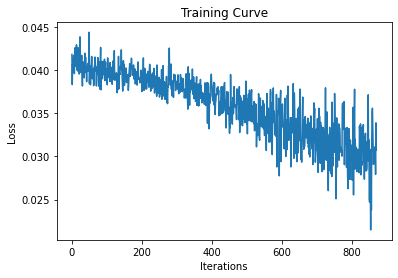

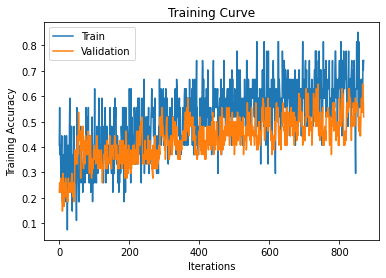

Epoch:  10 Train Accuracy:  0.6722009365687527 Val Accuracy:  0.5555555555555556 Progress:  22.00  % Time Elapsed:  544.14 s 
Epoch 10 Finished.  Time per Epoch:  49.47 s 
Epoch:  11 Train Accuracy:  0.6824180502341421 Val Accuracy:  0.5 Progress:  24.00  % Time Elapsed:  561.97 s 
Epoch 11 Finished.  Time per Epoch:  46.83 s 
Epoch:  12 Train Accuracy:  0.6862494678586633 Val Accuracy:  0.5555555555555556 Progress:  26.00  % Time Elapsed:  579.72 s 
Epoch 12 Finished.  Time per Epoch:  44.59 s 
Epoch:  13 Train Accuracy:  0.7151979565772669 Val Accuracy:  0.6111111111111112 Progress:  28.00  % Time Elapsed:  597.30 s 
Epoch 13 Finished.  Time per Epoch:  42.66 s 
Epoch:  14 Train Accuracy:  0.713495104299702 Val Accuracy:  0.6111111111111112 Progress:  30.00  % Time Elapsed:  615.15 s 
Epoch 14 Finished.  Time per Epoch:  41.01 s 
Epoch:  15 Train Accuracy:  0.7347807577692635 Val Accuracy:  0.6111111111111112 Progress:  32.00  % Time Elapsed:  632.91 s 
Epoch 15 Finished.  Time per E

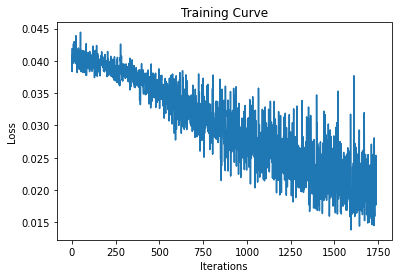

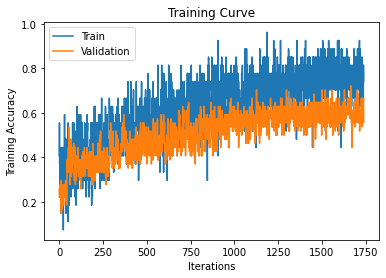

Epoch:  20 Train Accuracy:  0.7939548744146445 Val Accuracy:  0.7222222222222222 Progress:  42.00  % Time Elapsed:  722.10 s 
Epoch 20 Finished.  Time per Epoch:  34.39 s 
Epoch:  21 Train Accuracy:  0.7926777352064709 Val Accuracy:  0.6481481481481481 Progress:  44.00  % Time Elapsed:  740.06 s 
Epoch 21 Finished.  Time per Epoch:  33.64 s 
Epoch:  22 Train Accuracy:  0.8148148148148148 Val Accuracy:  0.6851851851851852 Progress:  46.00  % Time Elapsed:  758.11 s 
Epoch 22 Finished.  Time per Epoch:  32.96 s 
Epoch:  23 Train Accuracy:  0.8241805023414219 Val Accuracy:  0.6666666666666666 Progress:  48.00  % Time Elapsed:  775.93 s 
Epoch 23 Finished.  Time per Epoch:  32.33 s 
Epoch:  24 Train Accuracy:  0.8216262239250745 Val Accuracy:  0.6851851851851852 Progress:  50.00  % Time Elapsed:  793.77 s 
Epoch 24 Finished.  Time per Epoch:  31.75 s 
Epoch:  25 Train Accuracy:  0.8378033205619413 Val Accuracy:  0.6296296296296297 Progress:  52.00  % Time Elapsed:  812.34 s 
Epoch 25 Finis

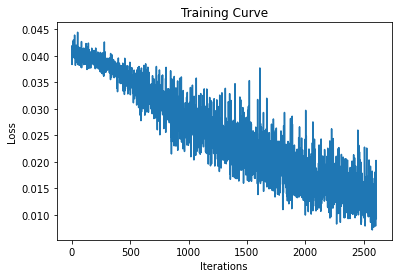

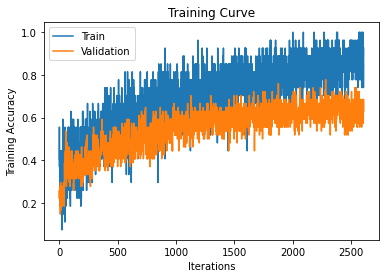

Epoch:  30 Train Accuracy:  0.8684546615581098 Val Accuracy:  0.5740740740740741 Progress:  62.00  % Time Elapsed:  901.30 s 
Epoch 30 Finished.  Time per Epoch:  29.07 s 
Epoch:  31 Train Accuracy:  0.8808003405704555 Val Accuracy:  0.6666666666666666 Progress:  64.00  % Time Elapsed:  919.32 s 
Epoch 31 Finished.  Time per Epoch:  28.73 s 
Epoch:  32 Train Accuracy:  0.8863346104725415 Val Accuracy:  0.6666666666666666 Progress:  66.00  % Time Elapsed:  937.32 s 
Epoch 32 Finished.  Time per Epoch:  28.40 s 
Epoch:  33 Train Accuracy:  0.8974031502767135 Val Accuracy:  0.6111111111111112 Progress:  68.00  % Time Elapsed:  955.52 s 
Epoch 33 Finished.  Time per Epoch:  28.10 s 
Epoch:  34 Train Accuracy:  0.9029374201787995 Val Accuracy:  0.6851851851851852 Progress:  70.00  % Time Elapsed:  973.43 s 
Epoch 34 Finished.  Time per Epoch:  27.81 s 
Epoch:  35 Train Accuracy:  0.9135802469135802 Val Accuracy:  0.6296296296296297 Progress:  72.00  % Time Elapsed:  991.34 s 
Epoch 35 Finis

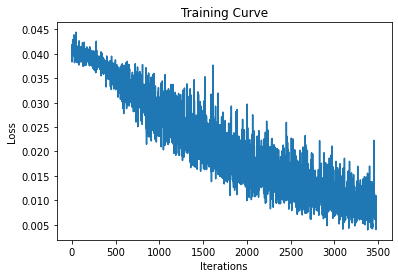

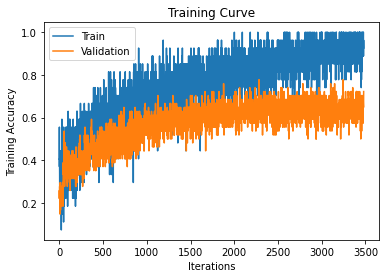

Epoch:  40 Train Accuracy:  0.9327373350361856 Val Accuracy:  0.6481481481481481 Progress:  82.00  % Time Elapsed:  1081.75 s 
Epoch 40 Finished.  Time per Epoch:  26.38 s 
Epoch:  41 Train Accuracy:  0.9399744572158365 Val Accuracy:  0.6481481481481481 Progress:  84.00  % Time Elapsed:  1099.78 s 
Epoch 41 Finished.  Time per Epoch:  26.19 s 
Epoch:  42 Train Accuracy:  0.9425287356321839 Val Accuracy:  0.6481481481481481 Progress:  86.00  % Time Elapsed:  1118.41 s 
Epoch 42 Finished.  Time per Epoch:  26.01 s 
Epoch:  43 Train Accuracy:  0.9476372924648787 Val Accuracy:  0.6296296296296297 Progress:  88.00  % Time Elapsed:  1136.29 s 
Epoch 43 Finished.  Time per Epoch:  25.82 s 
Epoch:  44 Train Accuracy:  0.9540229885057471 Val Accuracy:  0.5555555555555556 Progress:  90.00  % Time Elapsed:  1154.30 s 
Epoch 44 Finished.  Time per Epoch:  25.65 s 
Epoch:  45 Train Accuracy:  0.9531715623669647 Val Accuracy:  0.5740740740740741 Progress:  92.00  % Time Elapsed:  1172.54 s 
Epoch 45

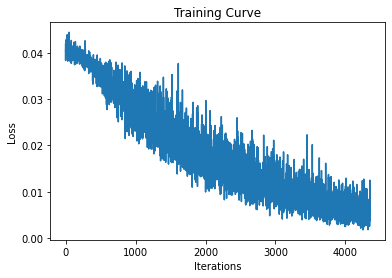

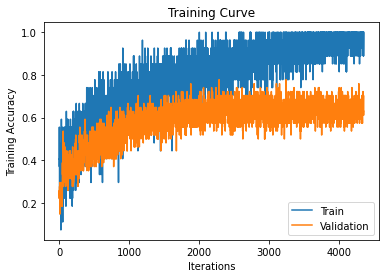

Finished Training
Total time:   1245.06 s  Time per Epoch:  24.90 s 


In [17]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.00005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_mixed_data_EMI_3classes_w_aug",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

Using CUDA
Epoch:  0 Train Accuracy:  0.42486164325244785 Val Accuracy:  0.4444444444444444 Progress:   2.00  % Time Elapsed:  18.17 s 
Epoch 0 Finished.  Time per Epoch:  18.17 s 
Epoch:  1 Train Accuracy:  0.5666240953597276 Val Accuracy:  0.6296296296296297 Progress:   4.00  % Time Elapsed:  36.31 s 
Epoch 1 Finished.  Time per Epoch:  18.15 s 
Epoch:  2 Train Accuracy:  0.7173265219242231 Val Accuracy:  0.5555555555555556 Progress:   6.00  % Time Elapsed:  54.19 s 
Epoch 2 Finished.  Time per Epoch:  18.06 s 
Epoch:  3 Train Accuracy:  0.8160919540229885 Val Accuracy:  0.7037037037037037 Progress:   8.00  % Time Elapsed:  72.25 s 
Epoch 3 Finished.  Time per Epoch:  18.06 s 
Epoch:  4 Train Accuracy:  0.9012345679012346 Val Accuracy:  0.6296296296296297 Progress:  10.00  % Time Elapsed:  90.49 s 
Epoch 4 Finished.  Time per Epoch:  18.10 s 
Epoch:  5 Train Accuracy:  0.9378458918688803 Val Accuracy:  0.6481481481481481 Progress:  12.00  % Time Elapsed:  108.91 s 
Epoch 5 Finished. 

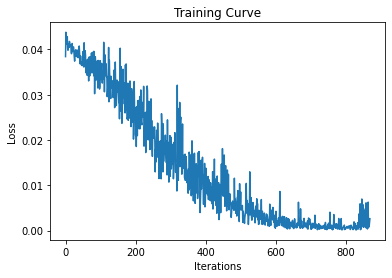

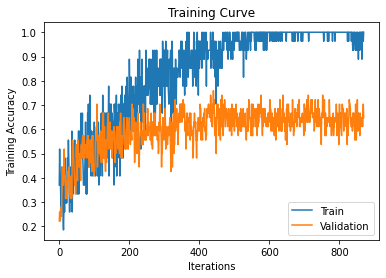

Epoch:  10 Train Accuracy:  0.9697743720732227 Val Accuracy:  0.6851851851851852 Progress:  22.00  % Time Elapsed:  207.95 s 
Epoch 10 Finished.  Time per Epoch:  18.90 s 
Epoch:  11 Train Accuracy:  0.9991485738612176 Val Accuracy:  0.6851851851851852 Progress:  24.00  % Time Elapsed:  234.75 s 
Epoch 11 Finished.  Time per Epoch:  19.56 s 
Epoch:  12 Train Accuracy:  0.9995742869306088 Val Accuracy:  0.6851851851851852 Progress:  26.00  % Time Elapsed:  261.70 s 
Epoch 12 Finished.  Time per Epoch:  20.13 s 
Epoch:  13 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  28.00  % Time Elapsed:  288.07 s 
Epoch 13 Finished.  Time per Epoch:  20.58 s 
Epoch:  14 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  30.00  % Time Elapsed:  314.63 s 
Epoch 14 Finished.  Time per Epoch:  20.98 s 
Epoch:  15 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  32.00  % Time Elapsed:  341.08 s 
Epoch 15 Finished.  Time per Epoch:  21.32 s 
Epoch:  16 Tr

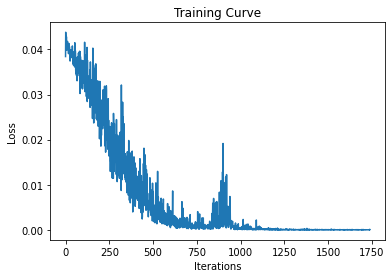

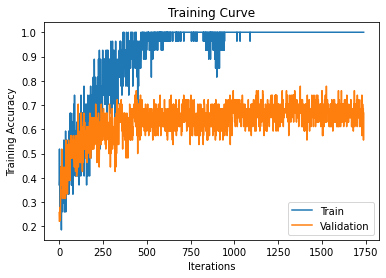

Epoch:  20 Train Accuracy:  1.0 Val Accuracy:  0.7592592592592593 Progress:  42.00  % Time Elapsed:  469.69 s 
Epoch 20 Finished.  Time per Epoch:  22.37 s 
Epoch:  21 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  44.00  % Time Elapsed:  488.11 s 
Epoch 21 Finished.  Time per Epoch:  22.19 s 
Epoch:  22 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  46.00  % Time Elapsed:  506.35 s 
Epoch 22 Finished.  Time per Epoch:  22.02 s 
Epoch:  23 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  48.00  % Time Elapsed:  524.66 s 
Epoch 23 Finished.  Time per Epoch:  21.86 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  50.00  % Time Elapsed:  542.81 s 
Epoch 24 Finished.  Time per Epoch:  21.71 s 
Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  52.00  % Time Elapsed:  561.31 s 
Epoch 25 Finished.  Time per Epoch:  21.59 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.703703703

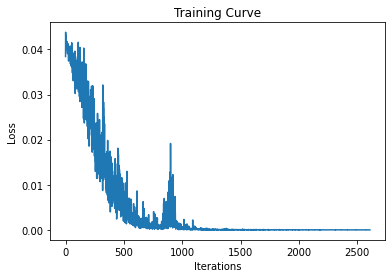

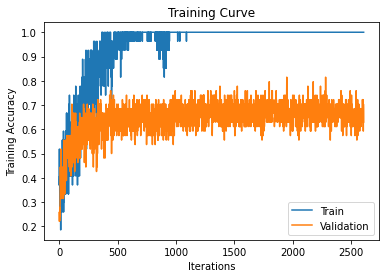

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  62.00  % Time Elapsed:  651.91 s 
Epoch 30 Finished.  Time per Epoch:  21.03 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  64.00  % Time Elapsed:  669.78 s 
Epoch 31 Finished.  Time per Epoch:  20.93 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  66.00  % Time Elapsed:  687.45 s 
Epoch 32 Finished.  Time per Epoch:  20.83 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  68.00  % Time Elapsed:  705.37 s 
Epoch 33 Finished.  Time per Epoch:  20.75 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  70.00  % Time Elapsed:  724.02 s 
Epoch 34 Finished.  Time per Epoch:  20.69 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  72.00  % Time Elapsed:  742.06 s 
Epoch 35 Finished.  Time per Epoch:  20.61 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.685185185

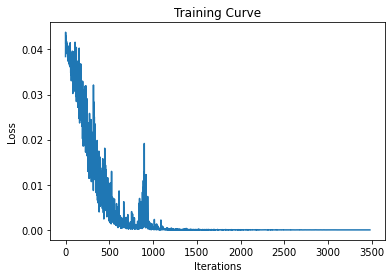

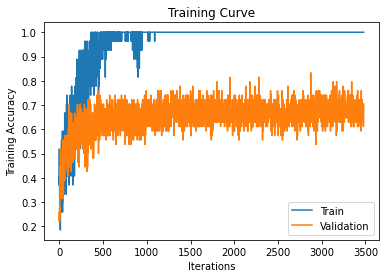

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  82.00  % Time Elapsed:  832.41 s 
Epoch 40 Finished.  Time per Epoch:  20.30 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  84.00  % Time Elapsed:  850.59 s 
Epoch 41 Finished.  Time per Epoch:  20.25 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  86.00  % Time Elapsed:  868.80 s 
Epoch 42 Finished.  Time per Epoch:  20.20 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  88.00  % Time Elapsed:  886.85 s 
Epoch 43 Finished.  Time per Epoch:  20.16 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  90.00  % Time Elapsed:  904.74 s 
Epoch 44 Finished.  Time per Epoch:  20.11 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  92.00  % Time Elapsed:  922.86 s 
Epoch 45 Finished.  Time per Epoch:  20.06 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.666666666

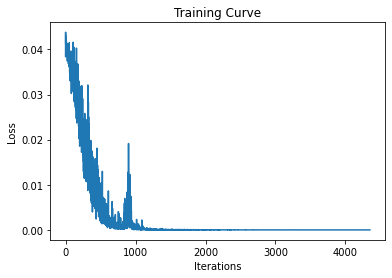

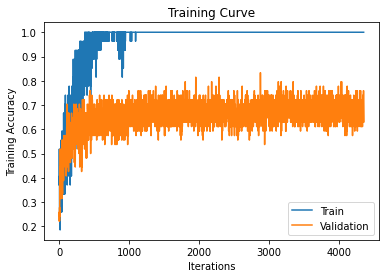

Finished Training
Total time:   995.07 s  Time per Epoch:  19.90 s 


In [18]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_10s_mixed_data_EMI_3classes_w_aug",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)